# Modules

In [1]:
%load_ext autoreload
%autoreload 2

import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader

sys.path.append("../")

from scarf.loss import NTXent
from scarf.model import SCARF, SCARF_modified, MLP

from example.dataset import ExampleDataset
from example.utils import dataset_embeddings, fix_seed, train_epoch

seed = 1234
fix_seed(seed)


# Data

In [2]:
from sklearn import preprocessing
import numpy as np
label_path = '../../data/TCGA/label.parquet'
data_path = '../../data/TCGA/pretrain_data.parquet'

class_df = pd.read_parquet(label_path)
data_df = pd.read_parquet(data_path)

# merging the dataframes based on "caseID"
class_df["caseID"] = class_df.apply(lambda row: row.cases.split("|")[1], axis=1)
df = class_df.merge(data_df, on="caseID", how="inner")
#df = class_df.iloc[:100].merge(data_df.iloc[:100], on="caseID", how="inner")
  
df = df.drop(columns=list(df.columns[:7]) + [df.columns[8]] + [df.columns[9]])  # columns management
    
# encoding cancer names to integers
le = preprocessing.LabelEncoder()
df["cancer_type"] = le.fit_transform(df["cancer_type"])
print(df.columns)
np_dataset = df.to_numpy(dtype=np.float32)

# normal standardardization
scaler = preprocessing.StandardScaler()
np_dataset[:, 1:] = scaler.fit_transform(np_dataset[:, 1:])
df = pd.DataFrame(np_dataset, columns=df.columns)

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)


In [3]:
df.columns

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)

In [4]:
#data = datasets.load_breast_cancer(as_frame=True)
#data, target = data["data"], data["target"]
#data = pd.read_parquet('../../data/TCGA/pretrain_data.parquet')
data, target = df.iloc[:,1:], df.iloc[:,0]
train_data, test_data, train_target, test_target = train_test_split(
    data,
    target,
    test_size=0.2,
    stratify=target,
    random_state=seed
)

# preprocess
constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
train_data.drop(columns=constant_cols, inplace=True)
test_data.drop(columns=constant_cols, inplace=True)

#scaler = StandardScaler()
#train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=df.columns)
#test_data = pd.DataFrame(scaler.transform(test_data), columns=df.columns)

# to torch dataset
train_ds = ExampleDataset(
    train_data.to_numpy(),
    train_target.to_numpy(),
    columns=train_data.columns
)
test_ds = ExampleDataset(
    test_data.to_numpy(),
    test_data.to_numpy(),
    columns=train_data.columns
)

print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")
train_ds.to_dataframe().head()

Train set: (5824, 56902)
Test set: (1457, 56902)


,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288658,ENSG00000288659,ENSG00000288660,ENSG00000288662,ENSG00000288663,ENSG00000288667,ENSG00000288669,ENSG00000288670,ENSG00000288674,ENSG00000288675
0,-0.207212,-0.065400,-1.553315,-0.429988,-0.406481,2.825986,-0.053623,-0.847602,-0.258823,0.005529,...,-0.364953,-0.099714,-0.189416,-0.230474,-0.743026,-0.22099,-0.111424,-1.533016,-0.019351,-0.583982
1,0.320597,-0.063374,0.010247,-0.546508,-0.322794,-0.337183,-0.288758,3.024102,-0.148423,-0.072450,...,-0.433215,-0.099714,0.075149,-0.230474,-0.432025,-0.22099,-0.111424,-0.740448,-0.032279,-0.308541
2,1.461309,-0.065400,0.001358,0.786946,0.126850,0.465826,-0.123203,0.264559,-0.198403,0.189371,...,0.951039,-0.099714,-0.235028,0.570803,0.796029,-0.22099,-0.111424,-0.200383,0.601221,-0.347547
3,-0.190479,-0.065400,-0.050470,0.986277,0.196270,0.509412,-0.187049,-0.712956,-0.506081,1.192426,...,-0.307581,-0.099714,-0.184623,0.797694,0.035045,-0.22099,-0.111424,0.658017,-0.027970,0.473674
4,-0.596489,0.027798,-0.762600,-0.655446,-0.914448,-0.385668,-0.360770,-0.860424,-0.302356,-0.541629,...,-0.325784,-0.099714,-0.235028,-0.230474,-0.979979,-0.22099,-0.111424,0.301331,-0.256374,0.149626


# Training

In [5]:
batch_size = 128
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = SCARF(
    input_dim=train_ds.shape[1],
    emb_dim=16,
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    nb_classes = len(np.unique(train_target)),
    corruption_rate=0.6,
    dropout=0.1
).to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
ntxent_loss = NTXent()

loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device)
    loss_history.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}")


epoch 10/100 - loss: 0.0405
epoch 20/100 - loss: 0.0396
epoch 30/100 - loss: 0.0392
epoch 40/100 - loss: 0.0390
epoch 50/100 - loss: 0.0388
epoch 60/100 - loss: 0.0388
epoch 70/100 - loss: 0.0387
epoch 80/100 - loss: 0.0386
epoch 90/100 - loss: 0.0387
epoch 100/100 - loss: 0.0387


Text(0, 0.5, 'loss')

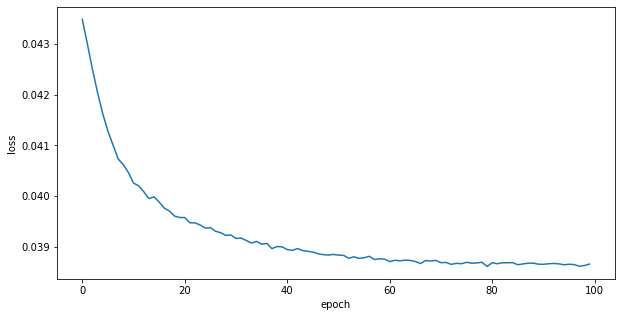

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

# Evaluate embeddings

In [7]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

(5824, 16)
(1457, 16)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       105
         1.0       0.95      0.98      0.97        62
         2.0       0.99      0.98      0.99       172
         3.0       1.00      0.92      0.96        48
         4.0       0.99      0.99      0.99        72
         5.0       0.92      0.94      0.93        81
         6.0       0.96      0.98      0.97        84
         7.0       1.00      0.93      0.97        46
         8.0       1.00      1.00      1.00        82
         9.0       0.97      1.00      0.98        57
        10.0       0.96      0.95      0.96        83
        11.0       0.91      0.90      0.91        80
        12.0       1.00      1.00      1.00        68
        13.0       1.00      0.99      0.99        76
        14.0       0.95      0.98      0.96        42
        15.0       0.99      0.99      0.99        71
        16.0       1.00      1.00      1.00        63
        17.0       1.00    

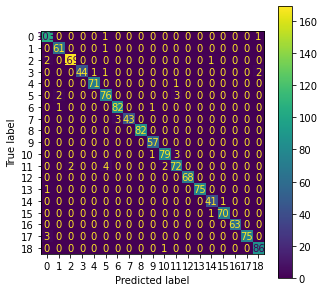

In [8]:
clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(train_data, train_target)
vanilla_predictions = clf.predict(test_data)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

              precision    recall  f1-score   support

         0.0       0.08      0.03      0.04       105
         1.0       0.21      0.10      0.13        62
         2.0       0.25      0.76      0.38       172
         3.0       0.00      0.00      0.00        48
         4.0       0.17      0.17      0.17        72
         5.0       0.49      0.63      0.55        81
         6.0       0.11      0.05      0.07        84
         7.0       0.33      0.04      0.08        46
         8.0       0.60      0.72      0.66        82
         9.0       0.37      0.49      0.42        57
        10.0       0.00      0.00      0.00        83
        11.0       0.24      0.25      0.24        80
        12.0       0.06      0.01      0.02        68
        13.0       0.20      0.32      0.24        76
        14.0       0.00      0.00      0.00        42
        15.0       0.00      0.00      0.00        71
        16.0       0.00      0.00      0.00        63
        17.0       0.29    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/py

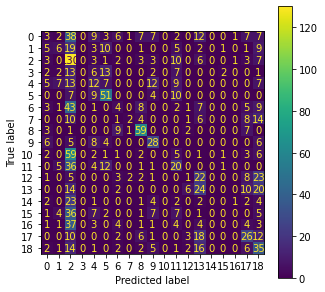

In [9]:
# embeddings dataset: train the classifier on the embeddings
clf.fit(train_embeddings, train_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

# Visualzie using t-sne 

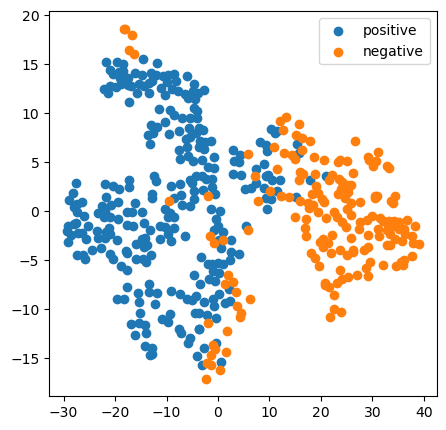

In [45]:
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(train_embeddings)
positive = train_target == 1

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

# New architecture

## Load pretraining Data

In [2]:
from sklearn import preprocessing
import numpy as np
label_path = '../../data/TCGA/label.parquet'
data_path = '../../data/TCGA/pretrain_data.parquet'

class_df = pd.read_parquet(label_path)
data_df = pd.read_parquet(data_path)

# merging the dataframes based on "caseID"
class_df["caseID"] = class_df.apply(lambda row: row.cases.split("|")[1], axis=1)
df = class_df.merge(data_df, on="caseID", how="inner")
#df = class_df.iloc[:100].merge(data_df.iloc[:100], on="caseID", how="inner")
  
df = df.drop(columns=list(df.columns[:7]) + [df.columns[8]] + [df.columns[9]])  # columns management
    
# encoding cancer names to integers
le = preprocessing.LabelEncoder()
df["cancer_type"] = le.fit_transform(df["cancer_type"])
print(df.columns)
np_dataset = df.to_numpy(dtype=np.float32)

# normal standardardization
scaler = preprocessing.StandardScaler()
np_dataset[:, 1:] = scaler.fit_transform(np_dataset[:, 1:])
df_pretraining = pd.DataFrame(np_dataset, columns=df.columns)

##########################
pretrain_data, pretrain_target = df_pretraining.iloc[:,1:], df_pretraining.iloc[:,0]

# preprocess
constant_cols = [c for c in pretrain_data.columns if pretrain_data[c].nunique() == 1]
pretrain_data.drop(columns=constant_cols, inplace=True)
pretrain_data.drop(columns=constant_cols, inplace=True)

# to torch dataset
pretrain_ds = ExampleDataset(
    pretrain_data.to_numpy(),
    pretrain_target.to_numpy(),
    columns=pretrain_data.columns
)

print(f"PreTrain set: {pretrain_ds.shape}")
pretrain_ds.to_dataframe().head()

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


PreTrain set: (7281, 56902)


,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288658,ENSG00000288659,ENSG00000288660,ENSG00000288662,ENSG00000288663,ENSG00000288667,ENSG00000288669,ENSG00000288670,ENSG00000288674,ENSG00000288675
0,10.933913,-0.038528,0.099030,1.323901,2.161303,-0.588663,-0.081665,-0.089608,0.021189,1.401538,...,-0.329847,-0.099714,-0.235028,1.883541,-0.278234,8.145715,-0.111424,1.408659,0.691721,-0.860022
1,0.539932,-0.063975,1.240584,0.567644,1.508072,-0.620745,-0.265434,0.763930,0.810315,0.408466,...,0.823779,-0.099714,-0.235028,-0.230474,0.088588,-0.220990,-0.111424,2.241555,-0.450303,-0.421358
2,3.707206,-0.063775,0.136488,-0.031701,-0.178531,-0.577479,-0.347451,1.333820,-0.316503,-0.547690,...,-0.397784,-0.099714,-0.217294,-0.230474,-0.575564,-0.220990,-0.111424,-0.039497,-0.359803,1.021255
3,0.244109,-0.063738,1.848756,1.207155,1.007615,0.587401,-0.063115,0.683785,2.190679,1.648934,...,-0.242732,-0.099714,-0.235028,-0.230474,2.650640,0.330042,-0.111424,1.559615,0.165959,0.065914
4,0.717637,-0.064502,-0.223943,0.802637,-0.531304,0.323034,-0.069960,0.214464,1.440103,1.129467,...,-0.335698,-0.099714,-0.215457,0.368316,1.263099,0.371430,-0.111424,-0.544741,-0.015041,-0.615186


## Load Finetuning Data

In [5]:
def generate_indices(data, prop=1, val_prop=0.15, test_prop=0.15, rs=0):
    """Generated train, validation and test indices that will be used in the
    dataloaders.

    Args:
        data (numpy.ndarray): 2-dimensional array of the dataset. The first column has
            to contain the class (ex: cancer / no cancer) information.
        prop (int, optional): Proportion of the dataset that is used to generate the
            indices. Defaults to 1.
        val_prop (float, optional): Proportion of data dedicated to the validation set.
            Defaults to 0.15.
        test_prop (float, optional): Proportion of data dedicated to the test set.
            Defaults to 0.15.
        rs (int, optional): Random state. Defaults to 0.

    Returns:
        (numpy.ndarray, numpy.ndarray, numpy.ndarray): Train, validation and test
        indices.
    """
    indices = list(range(len(data)))
    
    if test_prop != 0 :
        train_idx, test_idx = train_test_split(
            indices, test_size=test_prop, train_size=None, random_state=rs
        )
        train_idx, val_idx = train_test_split(
            train_idx,
            test_size=val_prop / (1 - test_prop),
            train_size=None,
            random_state=rs,
        )
    else :
        train_idx, val_idx = train_test_split(
            indices,
            test_size=val_prop,
            train_size=None,
            random_state=rs,
        )
        test_idx=[]
    if prop != 1:
        modes = data[train_idx, 0]
        subtrain_idx = []
        for mode in np.unique(modes):
            candidates = np.array(train_idx)[np.argwhere(modes == mode).flatten()]
            selected_idx = candidates[: round(len(candidates) * prop)]
            #selected_idx = np.random.choice(candidates, int(round(len(candidates)*prop)), replace=False)
            subtrain_idx += selected_idx.tolist()
        train_idx = subtrain_idx
        print(len(train_idx))

    return (train_idx, val_idx, test_idx)

In [4]:
from sklearn import preprocessing
import numpy as np
label_path = '../../data/TCGA/label.parquet'
data_path = '../../data/TCGA/nopretrain_data.parquet'

class_df = pd.read_parquet(label_path)
data_df = pd.read_parquet(data_path)

# merging the dataframes based on "caseID"
class_df["caseID"] = class_df.apply(lambda row: row.cases.split("|")[1], axis=1)
df = class_df.merge(data_df, on="caseID", how="inner")
#df = class_df.iloc[:100].merge(data_df.iloc[:100], on="caseID", how="inner")
  
df = df.drop(columns=list(df.columns[:7]) + [df.columns[8]] + [df.columns[9]])  # columns management
    
# encoding cancer names to integers
le = preprocessing.LabelEncoder()
df["cancer_type"] = le.fit_transform(df["cancer_type"])
print(df.columns)
np_dataset = df.to_numpy(dtype=np.float32)

# normal standardardization
scaler = preprocessing.StandardScaler()
np_dataset[:, 1:] = scaler.fit_transform(np_dataset[:, 1:])
df_finetuning = pd.DataFrame(np_dataset, columns=df.columns)

idx = generate_indices(df_finetuning, prop=1, val_prop=0.1, test_prop=0.5, rs=0)
finetuning_data = df_finetuning.iloc[idx[0]]
test_data = df_finetuning.iloc[idx[2]]

##########################
finetuning_data, finetuning_target = df_finetuning.iloc[:,1:], df_finetuning.iloc[:,0]
test_data, test_target = test_data.iloc[:,1:], test_data.iloc[:,0]

# preprocess
#constant_cols = [c for c in finetuning_data.columns if finetuning_data[c].nunique() == 1]
#finetuning_data.drop(columns=constant_cols, inplace=True)

# to torch dataset
finetuning_ds = ExampleDataset(
    finetuning_data.to_numpy(),
    finetuning_target.to_numpy(),
    columns=finetuning_data.columns
)

test_ds = ExampleDataset(
    test_data.to_numpy(),
    test_target.to_numpy(),
    columns=test_data.columns
)

print(f"Finetuning set: {finetuning_ds.shape}")
finetuning_ds.to_dataframe().head()

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)
Finetuning set: (2068, 56902)


,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288658,ENSG00000288659,ENSG00000288660,ENSG00000288662,ENSG00000288663,ENSG00000288667,ENSG00000288669,ENSG00000288670,ENSG00000288674,ENSG00000288675
0,9.155449,-0.041785,0.105929,-0.294168,-0.447419,0.481084,-0.291961,0.455926,0.911417,0.012106,...,-0.304207,-0.106617,-0.218545,-0.255868,2.212836,-0.235894,-0.190692,-0.462012,-0.442235,-0.102772
1,-0.470730,-0.061825,-1.420002,-0.890365,-0.792608,-0.603786,-0.340088,-0.816232,-0.501949,-1.110046,...,-0.470219,-0.106617,-0.178497,-0.255868,0.626263,0.578191,-0.190692,-1.153313,-0.743321,-0.224095
2,1.226317,-0.062687,-0.551827,-0.296947,-0.515758,-0.318575,0.125923,0.702616,-0.123899,-0.418156,...,-0.367522,-0.106617,-0.218545,-0.255868,1.095909,-0.235894,-0.190692,-0.875645,-0.495368,-0.084673
3,7.914614,-0.062022,0.536457,0.118510,1.515536,-0.663437,-0.353701,-0.350872,5.220117,2.213786,...,0.836959,-0.106617,-0.203117,-0.255868,-0.427396,-0.235894,-0.190692,-0.472953,-0.353680,-0.289139
4,-0.157519,-0.061397,-0.394317,-0.702957,-0.426219,-0.609323,-0.315378,-0.161219,0.415225,-0.542954,...,-0.388061,-0.106617,-0.218545,-0.255868,0.773484,0.371983,0.300610,2.857993,-1.000131,-0.796770


In [5]:
finetuning_ds.shape, pretrain_ds.shape, test_ds.shape

((2068, 56902), (7281, 56902), (1034, 56902))

## Finetuning

### Load Model

In [6]:
!ls ../saved_models

scarf_encoder_1024emb_10enc_statedict_1000epochs.pt
scarf_encoder_1024emb_4enc_statedict_1000epochs.pt
scarf_encoder_1024emb_4hid_statedict_1000epochs.pt
scarf_encoder_1024emb_5enc_statedict_1000epochs.pt
scarf_encoder_1024emb_6enc_statedict_1000epochs.pt
scarf_encoder_1024emb_7enc_statedict_1000epochs.pt
scarf_encoder_1024emb_8enc_statedict_1000epochs.pt
scarf_encoder_1024emb_9enc_statedict_1000epochs.pt
scarf_encoder_1024.pt
scarf_encoder_1024_statedict.pt
scarf_encoder_128emb_4enc_statedict_1000epochs.pt
scarf_encoder_32emb_4enc_statedict_1000epochs.pt
scarf_encoder_512emb_10enc_statedict_1000epochs.pt
scarf_encoder_512emb_4enc_statedict_1000epochs.pt
scarf_encoder_512emb_5enc_statedict_1000epochs.pt
scarf_encoder_512emb_6enc_statedict_1000epochs.pt
scarf_encoder_512emb_7enc_statedict_1000epochs.pt
scarf_encoder_64emb_4enc_statedict_1000epochs.pt
scarf_encoder_modified_statedict_1000epochs_balanced.pt
scarf_encoder_modified_statedict_1000epochs_BTloss.pt
scarf_encoder_modified_state

In [7]:
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
nb_classes = len(np.unique(pretrain_target))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# build model
encoder = SCARF_modified(
    input_dim=pretrain_ds.shape[1],
    emb_dim=64, # 16 by default, augment in the future
    features_low=pretrain_ds.features_low,
    features_high=pretrain_ds.features_high,
    nb_classes=nb_classes,
    corruption_rate=corruption_rate,
    dropout=dropout
).to(device)

#encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs_balanced.pt"), strict=False)
encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs_lr1e-4.pt"), strict=False)

cuda


<All keys matched successfully>

### LogReg

In [8]:
train_loader = DataLoader(finetuning_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(encoder, train_loader, device)
test_embeddings = dataset_embeddings(encoder, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

(2068, 64)
(1034, 64)


              precision    recall  f1-score   support

         0.0       0.32      0.32      0.32        79
         1.0       0.17      0.02      0.03        56
         2.0       0.67      0.86      0.75       112
         3.0       0.00      0.00      0.00        28
         4.0       0.86      1.00      0.92        60
         5.0       0.30      0.45      0.36        56
         6.0       0.61      0.57      0.59        58
         7.0       0.00      0.00      0.00        22
         8.0       0.56      0.85      0.67        65
         9.0       0.69      0.88      0.77        48
        10.0       0.67      0.28      0.39        50
        11.0       0.37      0.69      0.48        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.60      0.38      0.46        56
        16.0       0.85      0.81      0.83        43
        17.0       0.87    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

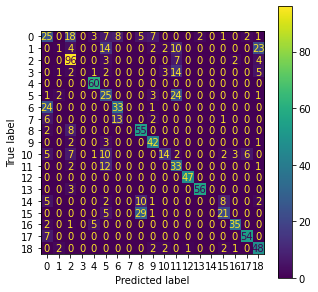

In [27]:
# embeddings dataset: train the classifier on the embeddings
clf = LogisticRegression()

clf.fit(train_embeddings, finetuning_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

## LogReg with proportion

In [9]:
###################### LOAD MODEL ################################
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
nb_classes = len(np.unique(pretrain_target))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# build model
encoder = SCARF_modified(
    input_dim=pretrain_ds.shape[1],
    emb_dim=64, # 16 by default, augment in the future
    features_low=pretrain_ds.features_low,
    features_high=pretrain_ds.features_high,
    nb_classes=nb_classes,
    corruption_rate=corruption_rate,
    dropout=dropout
).to(device)

#encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs_balanced.pt"), strict=False)
encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs_lr1e-4.pt"), strict=False)

cuda


<All keys matched successfully>

In [10]:
np.array(df_finetuning)

array([[ 1.        ,  9.155449  , -0.04178456, ..., -0.46201226,
        -0.4422349 , -0.10277236],
       [ 1.        , -0.47072977, -0.06182518, ..., -1.1533126 ,
        -0.7433215 , -0.22409461],
       [ 1.        ,  1.226317  , -0.06268745, ..., -0.87564534,
        -0.49536785, -0.08467294],
       ...,
       [ 0.        ,  0.2397451 , -0.061008  , ..., -0.29250085,
         0.859522  , -0.4330857 ],
       [ 0.        ,  0.19451827, -0.05727715, ..., -0.7005429 ,
        -0.3448245 ,  0.7951257 ],
       [18.        ,  0.6227987 , -0.05079044, ..., -0.64145255,
         1.2314526 , -0.2667978 ]], dtype=float32)

In [11]:
name = "scarf_encoder_modified_statedict_1000epochs_lr1e-4.2.pt.csv"
prop_list = np.arange(0.02, 1.01, 0.01)
csv_history = pd.DataFrame(columns=['test_acc', 'prop'])

results = []

for prop in prop_list :
    for i in range(1) :
        print(prop)
        ################# SPLIT DATA #####################
        idx = generate_indices(np.array(df_finetuning), prop=prop, val_prop=0.1, test_prop=0.5, rs=0)
        finetuning_data = df_finetuning.iloc[idx[0]]
        test_data = df_finetuning.iloc[idx[2]]

        finetuning_data, finetuning_target = finetuning_data.iloc[:,1:], finetuning_data.iloc[:,0]
        test_data, test_target = test_data.iloc[:,1:], test_data.iloc[:,0]

        # preprocess
        #constant_cols = [c for c in finetuning_data.columns if finetuning_data[c].nunique() == 1]
        #finetuning_data.drop(columns=constant_cols, inplace=True)

        # to torch dataset
        finetuning_ds = ExampleDataset(
            finetuning_data.to_numpy(),
            finetuning_target.to_numpy(),
            columns=finetuning_data.columns
        )

        test_ds = ExampleDataset(
            test_data.to_numpy(),
            test_target.to_numpy(),
            columns=test_data.columns
        )

        print(f"Finetuning set: {finetuning_ds.shape}")
        print(f"Test set: {test_ds.shape}")
        
        
        ################## GET EMBEDDINGS ##########################
        train_loader = DataLoader(finetuning_ds, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

        # get embeddings for training and test set
        train_embeddings = dataset_embeddings(encoder, train_loader, device)
        test_embeddings = dataset_embeddings(encoder, test_loader, device)

        print(train_embeddings.shape)
        print(test_embeddings.shape)
        
        
        ######################### TRAIN LOGREG ####################################
        # embeddings dataset: train the classifier on the embeddings
        clf = LogisticRegression()

        clf.fit(train_embeddings, finetuning_target)
        vanilla_predictions = clf.predict(test_embeddings)

        print(classification_report(test_target, vanilla_predictions))
        
        results.append(clf.score(test_embeddings, test_target))
        
        ################ SAVE CSV ######################
        csv_history.loc[len(csv_history)] = [results[-1], prop]
    csv_history.to_csv(name)

0.02
19
Finetuning set: (19, 56902)
Test set: (1034, 56902)
(19, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.28      0.11      0.16        79
         1.0       0.93      0.70      0.80        56
         2.0       0.83      0.96      0.89       112
         3.0       0.54      0.46      0.50        28
         4.0       0.91      0.83      0.87        60
         5.0       0.67      0.70      0.68        56
         6.0       0.79      0.83      0.81        58
         7.0       0.56      0.82      0.67        22
         8.0       1.00      0.97      0.98        65
         9.0       0.86      0.92      0.89        48
        10.0       0.74      0.86      0.80        50
        11.0       0.71      0.73      0.72        48
        12.0       1.00      1.00      1.00        47
        13.0       0.95      0.98      0.97        59
        14.0       0.00      0.00      0.00        28
        15.0       0.75      1.00      0.85        56
        16.0       0.74      0.93      0.82        43
        17.0       0.91    

In [ ]:
list_model = ["scarf_encoder_modified_statedict_1000epochs_balanced.pt", "scarf_encoder_modified_statedict_1000epochs_BTloss.pt", "scarf_encoder_modified_statedict_1000epochs_dropout05.pt", "scarf_encoder_modified_statedict_1000epochs_lr1e-4.pt", "scarf_encoder_modified_statedict_1000epochs_SGD.pt"]

for model in list_model :
    ###################### LOAD MODEL ################################
    corruption_rate = 0.5
    dropout = 0.1
    batch_size = 256
    nb_classes = len(np.unique(pretrain_target))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)


    # build model
    encoder = SCARF_modified(
        input_dim=pretrain_ds.shape[1],
        emb_dim=64, # 16 by default, augment in the future
        features_low=pretrain_ds.features_low,
        features_high=pretrain_ds.features_high,
        nb_classes=nb_classes,
        corruption_rate=corruption_rate,
        dropout=dropout
    ).to(device)

    #encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs_balanced.pt"), strict=False)
    encoder.load_state_dict(torch.load(f"../saved_models/{model}"), strict=False)
    
    name = f"{model}.csv"
    prop_list = np.arange(0.02, 1.01, 0.01)
    csv_history = pd.DataFrame(columns=['test_acc', 'prop'])

    results = []

    for prop in prop_list :
        for i in range(5) :
            print(prop)
            ################# SPLIT DATA #####################
            idx = generate_indices(np.array(df_finetuning), prop=prop, val_prop=0.1, test_prop=0.5, rs=0)
            finetuning_data = df_finetuning.iloc[idx[0]]
            test_data = df_finetuning.iloc[idx[2]]

            finetuning_data, finetuning_target = finetuning_data.iloc[:,1:], finetuning_data.iloc[:,0]
            test_data, test_target = test_data.iloc[:,1:], test_data.iloc[:,0]

            # preprocess
            #constant_cols = [c for c in finetuning_data.columns if finetuning_data[c].nunique() == 1]
            #finetuning_data.drop(columns=constant_cols, inplace=True)

            # to torch dataset
            finetuning_ds = ExampleDataset(
                finetuning_data.to_numpy(),
                finetuning_target.to_numpy(),
                columns=finetuning_data.columns
            )

            test_ds = ExampleDataset(
                test_data.to_numpy(),
                test_target.to_numpy(),
                columns=test_data.columns
            )

            print(f"Finetuning set: {finetuning_ds.shape}")
            print(f"Test set: {test_ds.shape}")


            ################## GET EMBEDDINGS ##########################
            train_loader = DataLoader(finetuning_ds, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

            # get embeddings for training and test set
            train_embeddings = dataset_embeddings(encoder, train_loader, device)
            test_embeddings = dataset_embeddings(encoder, test_loader, device)

            print(train_embeddings.shape)
            print(test_embeddings.shape)


            ######################### TRAIN LOGREG ####################################
            # embeddings dataset: train the classifier on the embeddings
            clf = LogisticRegression()

            clf.fit(train_embeddings, finetuning_target)
            vanilla_predictions = clf.predict(test_embeddings)

            print(classification_report(test_target, vanilla_predictions))

            results.append(clf.score(test_embeddings, test_target))

            ################ SAVE CSV ######################
            csv_history.loc[len(csv_history)] = [results[-1], prop]
        csv_history.to_csv(name)


cuda
0.02
19
Finetuning set: (19, 56902)
Test set: (1034, 56902)
(19, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.11      1.00      0.20       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.45      0.62        65
         9.0       0.67      0.29      0.41        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
        17.0       0.00    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

19
Finetuning set: (19, 56902)
Test set: (1034, 56902)
(19, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.11      1.00      0.20       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.45      0.62        65
         9.0       0.67      0.29      0.41        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(19, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.11      1.00      0.20       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.45      0.62        65
         9.0       0.67      0.29      0.41        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(19, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.11      1.00      0.20       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.45      0.62        65
         9.0       0.67      0.29      0.41        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (22, 56902)
Test set: (1034, 56902)
(22, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.19      0.14      0.16        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.17      0.29        65
         9.0       0.00      0.00      0.00        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

22
Finetuning set: (22, 56902)
Test set: (1034, 56902)
(22, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.19      0.14      0.16        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.17      0.29        65
         9.0       0.00      0.00      0.00        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(22, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.19      0.14      0.16        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.17      0.29        65
         9.0       0.00      0.00      0.00        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(22, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.19      0.14      0.16        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.17      0.29        65
         9.0       0.00      0.00      0.00        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(22, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.19      0.14      0.16        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.17      0.29        65
         9.0       0.00      0.00      0.00        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (33, 56902)
Test set: (1034, 56902)
(33, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.11      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.85      0.92        65
         9.0       0.00      0.00      0.00        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (33, 56902)
Test set: (1034, 56902)
(33, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.11      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.85      0.92        65
         9.0       0.00      0.00      0.00        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

33
Finetuning set: (33, 56902)
Test set: (1034, 56902)
(33, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.11      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.85      0.92        65
         9.0       0.00      0.00      0.00        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(33, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.11      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.85      0.92        65
         9.0       0.00      0.00      0.00        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(33, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.11      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.85      0.92        65
         9.0       0.00      0.00      0.00        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(40, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.10      0.04      0.05        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.22       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.74      0.85        65
         9.0       0.80      0.58      0.67        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(40, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.10      0.04      0.05        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.22       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.74      0.85        65
         9.0       0.80      0.58      0.67        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(40, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.10      0.04      0.05        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.22       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.74      0.85        65
         9.0       0.80      0.58      0.67        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(40, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.10      0.04      0.05        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.22       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.74      0.85        65
         9.0       0.80      0.58      0.67        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(40, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.10      0.04      0.05        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.22       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.00      0.00      0.00        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.74      0.85        65
         9.0       0.80      0.58      0.67        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (51, 56902)
Test set: (1034, 56902)
(51, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.22       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.77      0.36      0.49        56
         6.0       0.17      0.02      0.03        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.89      0.94        65
         9.0       0.72      0.38      0.49        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       1.00      0.07      0.13        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

51
Finetuning set: (51, 56902)
Test set: (1034, 56902)
(51, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.22       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.77      0.36      0.49        56
         6.0       0.17      0.02      0.03        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.89      0.94        65
         9.0       0.72      0.38      0.49        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       1.00      0.07      0.13        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (51, 56902)
Test set: (1034, 56902)
(51, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.22       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.77      0.36      0.49        56
         6.0       0.17      0.02      0.03        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.89      0.94        65
         9.0       0.72      0.38      0.49        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       1.00      0.07      0.13        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

51
Finetuning set: (51, 56902)
Test set: (1034, 56902)
(51, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.22       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.77      0.36      0.49        56
         6.0       0.17      0.02      0.03        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.89      0.94        65
         9.0       0.72      0.38      0.49        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       1.00      0.07      0.13        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (51, 56902)
Test set: (1034, 56902)
(51, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.22       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.77      0.36      0.49        56
         6.0       0.17      0.02      0.03        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.89      0.94        65
         9.0       0.72      0.38      0.49        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       1.00      0.07      0.13        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

57
Finetuning set: (57, 56902)
Test set: (1034, 56902)
(57, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.89      0.14      0.25        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.85      0.92        65
         9.0       0.67      0.29      0.41        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.11      0.19        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (57, 56902)
Test set: (1034, 56902)
(57, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.89      0.14      0.25        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.85      0.92        65
         9.0       0.67      0.29      0.41        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.11      0.19        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

57
Finetuning set: (57, 56902)
Test set: (1034, 56902)
(57, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.89      0.14      0.25        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.85      0.92        65
         9.0       0.67      0.29      0.41        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.11      0.19        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (57, 56902)
Test set: (1034, 56902)
(57, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.89      0.14      0.25        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.85      0.92        65
         9.0       0.67      0.29      0.41        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.11      0.19        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (57, 56902)
Test set: (1034, 56902)
(57, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        79
         1.0       0.00      0.00      0.00        56
         2.0       0.12      1.00      0.21       112
         3.0       0.00      0.00      0.00        28
         4.0       0.00      0.00      0.00        60
         5.0       0.89      0.14      0.25        56
         6.0       0.00      0.00      0.00        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.85      0.92        65
         9.0       0.67      0.29      0.41        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.11      0.19        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.00      0.00      0.00        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

66
Finetuning set: (66, 56902)
Test set: (1034, 56902)
(66, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.13      0.05      0.07        79
         1.0       0.00      0.00      0.00        56
         2.0       0.15      1.00      0.25       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.03      0.06        60
         5.0       0.69      0.64      0.67        56
         6.0       0.58      0.59      0.58        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.94      0.97        65
         9.0       0.63      0.25      0.36        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.09      0.16        47
        13.0       1.00      0.03      0.07        59
        14.0       0.00      0.00      0.00        28
        15.0       0.82      0.50      0.62        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(66, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.13      0.05      0.07        79
         1.0       0.00      0.00      0.00        56
         2.0       0.15      1.00      0.25       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.03      0.06        60
         5.0       0.69      0.64      0.67        56
         6.0       0.58      0.59      0.58        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.94      0.97        65
         9.0       0.63      0.25      0.36        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.09      0.16        47
        13.0       1.00      0.03      0.07        59
        14.0       0.00      0.00      0.00        28
        15.0       0.82      0.50      0.62        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(66, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.13      0.05      0.07        79
         1.0       0.00      0.00      0.00        56
         2.0       0.15      1.00      0.25       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.03      0.06        60
         5.0       0.69      0.64      0.67        56
         6.0       0.58      0.59      0.58        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.94      0.97        65
         9.0       0.63      0.25      0.36        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.09      0.16        47
        13.0       1.00      0.03      0.07        59
        14.0       0.00      0.00      0.00        28
        15.0       0.82      0.50      0.62        56
        16.0       0.00      0.00      0.00        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (66, 56902)
Test set: (1034, 56902)
(66, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.13      0.05      0.07        79
         1.0       0.00      0.00      0.00        56
         2.0       0.15      1.00      0.25       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.03      0.06        60
         5.0       0.69      0.64      0.67        56
         6.0       0.58      0.59      0.58        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.94      0.97        65
         9.0       0.63      0.25      0.36        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.09      0.16        47
        13.0       1.00      0.03      0.07        59
        14.0       0.00      0.00      0.00        28
        15.0       0.82      0.50      0.62        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

66
Finetuning set: (66, 56902)
Test set: (1034, 56902)
(66, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.13      0.05      0.07        79
         1.0       0.00      0.00      0.00        56
         2.0       0.15      1.00      0.25       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.03      0.06        60
         5.0       0.69      0.64      0.67        56
         6.0       0.58      0.59      0.58        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.94      0.97        65
         9.0       0.63      0.25      0.36        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.09      0.16        47
        13.0       1.00      0.03      0.07        59
        14.0       0.00      0.00      0.00        28
        15.0       0.82      0.50      0.62        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (75, 56902)
Test set: (1034, 56902)
(75, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.08      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.14      1.00      0.25       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.77      0.64      0.70        56
         6.0       0.54      0.33      0.41        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.92      0.96        65
         9.0       0.82      0.69      0.75        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.04      0.08        47
        13.0       1.00      0.02      0.03        59
        14.0       0.00      0.00      0.00        28
        15.0       0.86      0.32      0.47        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

75
Finetuning set: (75, 56902)
Test set: (1034, 56902)
(75, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.08      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.14      1.00      0.25       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.77      0.64      0.70        56
         6.0       0.54      0.33      0.41        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.92      0.96        65
         9.0       0.82      0.69      0.75        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.04      0.08        47
        13.0       1.00      0.02      0.03        59
        14.0       0.00      0.00      0.00        28
        15.0       0.86      0.32      0.47        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

(75, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.08      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.14      1.00      0.25       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.77      0.64      0.70        56
         6.0       0.54      0.33      0.41        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.92      0.96        65
         9.0       0.82      0.69      0.75        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.04      0.08        47
        13.0       1.00      0.02      0.03        59
        14.0       0.00      0.00      0.00        28
        15.0       0.86      0.32      0.47        56
        16.0       1.00      0.07      0.13        43
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (75, 56902)
Test set: (1034, 56902)
(75, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.08      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.14      1.00      0.25       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.77      0.64      0.70        56
         6.0       0.54      0.33      0.41        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.92      0.96        65
         9.0       0.82      0.69      0.75        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.04      0.08        47
        13.0       1.00      0.02      0.03        59
        14.0       0.00      0.00      0.00        28
        15.0       0.86      0.32      0.47        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

75
Finetuning set: (75, 56902)
Test set: (1034, 56902)
(75, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.08      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.14      1.00      0.25       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.77      0.64      0.70        56
         6.0       0.54      0.33      0.41        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.92      0.96        65
         9.0       0.82      0.69      0.75        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.04      0.08        47
        13.0       1.00      0.02      0.03        59
        14.0       0.00      0.00      0.00        28
        15.0       0.86      0.32      0.47        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (82, 56902)
Test set: (1034, 56902)
(82, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.20      0.09      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.16      1.00      0.27       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.64      0.84      0.73        56
         6.0       0.39      0.16      0.22        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.82      0.65      0.72        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.95      0.43      0.59        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.73      0.82      0.77        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

82
Finetuning set: (82, 56902)
Test set: (1034, 56902)
(82, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.20      0.09      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.16      1.00      0.27       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.64      0.84      0.73        56
         6.0       0.39      0.16      0.22        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.82      0.65      0.72        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.95      0.43      0.59        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.73      0.82      0.77        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (82, 56902)
Test set: (1034, 56902)
(82, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.20      0.09      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.16      1.00      0.27       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.64      0.84      0.73        56
         6.0       0.39      0.16      0.22        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.82      0.65      0.72        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.95      0.43      0.59        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.73      0.82      0.77        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

82
Finetuning set: (82, 56902)
Test set: (1034, 56902)
(82, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.20      0.09      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.16      1.00      0.27       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.64      0.84      0.73        56
         6.0       0.39      0.16      0.22        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.82      0.65      0.72        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.95      0.43      0.59        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.73      0.82      0.77        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (82, 56902)
Test set: (1034, 56902)
(82, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.20      0.09      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.16      1.00      0.27       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.02      0.03        60
         5.0       0.64      0.84      0.73        56
         6.0       0.39      0.16      0.22        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.82      0.65      0.72        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       0.95      0.43      0.59        47
        13.0       0.00      0.00      0.00        59
        14.0       0.00      0.00      0.00        28
        15.0       0.73      0.82      0.77        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

90
Finetuning set: (90, 56902)
Test set: (1034, 56902)
(90, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.11      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.17      1.00      0.29       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.25      0.39        60
         5.0       0.68      0.80      0.74        56
         6.0       0.59      0.72      0.65        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.94      0.97        65
         9.0       0.81      0.62      0.71        48
        10.0       0.00      0.00      0.00        50
        11.0       0.14      0.02      0.04        48
        12.0       1.00      0.38      0.55        47
        13.0       1.00      0.10      0.18        59
        14.0       0.00      0.00      0.00        28
        15.0       0.75      0.71      0.73        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (90, 56902)
Test set: (1034, 56902)
(90, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.11      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.17      1.00      0.29       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.25      0.39        60
         5.0       0.68      0.80      0.74        56
         6.0       0.59      0.72      0.65        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.94      0.97        65
         9.0       0.81      0.62      0.71        48
        10.0       0.00      0.00      0.00        50
        11.0       0.14      0.02      0.04        48
        12.0       1.00      0.38      0.55        47
        13.0       1.00      0.10      0.18        59
        14.0       0.00      0.00      0.00        28
        15.0       0.75      0.71      0.73        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

90
Finetuning set: (90, 56902)
Test set: (1034, 56902)
(90, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.11      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.17      1.00      0.29       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.25      0.39        60
         5.0       0.68      0.80      0.74        56
         6.0       0.59      0.72      0.65        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.94      0.97        65
         9.0       0.81      0.62      0.71        48
        10.0       0.00      0.00      0.00        50
        11.0       0.14      0.02      0.04        48
        12.0       1.00      0.38      0.55        47
        13.0       1.00      0.10      0.18        59
        14.0       0.00      0.00      0.00        28
        15.0       0.75      0.71      0.73        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (90, 56902)
Test set: (1034, 56902)
(90, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.11      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.17      1.00      0.29       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.25      0.39        60
         5.0       0.68      0.80      0.74        56
         6.0       0.59      0.72      0.65        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.94      0.97        65
         9.0       0.81      0.62      0.71        48
        10.0       0.00      0.00      0.00        50
        11.0       0.14      0.02      0.04        48
        12.0       1.00      0.38      0.55        47
        13.0       1.00      0.10      0.18        59
        14.0       0.00      0.00      0.00        28
        15.0       0.75      0.71      0.73        56
        1

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

90
Finetuning set: (90, 56902)
Test set: (1034, 56902)
(90, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.11      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.17      1.00      0.29       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.25      0.39        60
         5.0       0.68      0.80      0.74        56
         6.0       0.59      0.72      0.65        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.94      0.97        65
         9.0       0.81      0.62      0.71        48
        10.0       0.00      0.00      0.00        50
        11.0       0.14      0.02      0.04        48
        12.0       1.00      0.38      0.55        47
        13.0       1.00      0.10      0.18        59
        14.0       0.00      0.00      0.00        28
        15.0       0.75      0.71      0.73        56
      

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (100, 56902)
Test set: (1034, 56902)
(100, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.21      0.09      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.18      1.00      0.30       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.23      0.38        60
         5.0       0.62      0.88      0.73        56
         6.0       0.56      0.57      0.56        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.30      0.46        47
        13.0       1.00      0.03      0.07        59
        14.0       0.00      0.00      0.00        28
        15.0       0.67      0.91      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

100
Finetuning set: (100, 56902)
Test set: (1034, 56902)
(100, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.21      0.09      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.18      1.00      0.30       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.23      0.38        60
         5.0       0.62      0.88      0.73        56
         6.0       0.56      0.57      0.56        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.30      0.46        47
        13.0       1.00      0.03      0.07        59
        14.0       0.00      0.00      0.00        28
        15.0       0.67      0.91      0.77        56
   

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (100, 56902)
Test set: (1034, 56902)
(100, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.21      0.09      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.18      1.00      0.30       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.23      0.38        60
         5.0       0.62      0.88      0.73        56
         6.0       0.56      0.57      0.56        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.30      0.46        47
        13.0       1.00      0.03      0.07        59
        14.0       0.00      0.00      0.00        28
        15.0       0.67      0.91      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (100, 56902)
Test set: (1034, 56902)
(100, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.21      0.09      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.18      1.00      0.30       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.23      0.38        60
         5.0       0.62      0.88      0.73        56
         6.0       0.56      0.57      0.56        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.30      0.46        47
        13.0       1.00      0.03      0.07        59
        14.0       0.00      0.00      0.00        28
        15.0       0.67      0.91      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

100
Finetuning set: (100, 56902)
Test set: (1034, 56902)
(100, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.21      0.09      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.18      1.00      0.30       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.23      0.38        60
         5.0       0.62      0.88      0.73        56
         6.0       0.56      0.57      0.56        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.30      0.46        47
        13.0       1.00      0.03      0.07        59
        14.0       0.00      0.00      0.00        28
        15.0       0.67      0.91      0.77        56
   

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (107, 56902)
Test set: (1034, 56902)
(107, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.12      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.20      0.98      0.34       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.20      0.33        60
         5.0       0.64      0.84      0.73        56
         6.0       0.61      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.74      0.85        47
        13.0       1.00      0.51      0.67        59
        14.0       0.00      0.00      0.00        28
        15.0       0.69      0.86      0.76        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

107
Finetuning set: (107, 56902)
Test set: (1034, 56902)
(107, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.12      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.20      0.98      0.34       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.20      0.33        60
         5.0       0.64      0.84      0.73        56
         6.0       0.61      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.74      0.85        47
        13.0       1.00      0.51      0.67        59
        14.0       0.00      0.00      0.00        28
        15.0       0.69      0.86      0.76        56
   

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (107, 56902)
Test set: (1034, 56902)
(107, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.12      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.20      0.98      0.34       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.20      0.33        60
         5.0       0.64      0.84      0.73        56
         6.0       0.61      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.74      0.85        47
        13.0       1.00      0.51      0.67        59
        14.0       0.00      0.00      0.00        28
        15.0       0.69      0.86      0.76        56
        16.0       0.84      0.72      0.77        43
        17.0       0.97    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (107, 56902)
Test set: (1034, 56902)
(107, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.12      0.03      0.04        79
         1.0       0.00      0.00      0.00        56
         2.0       0.20      0.98      0.34       112
         3.0       0.00      0.00      0.00        28
         4.0       1.00      0.20      0.33        60
         5.0       0.64      0.84      0.73        56
         6.0       0.61      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.00      0.00      0.00        48
        12.0       1.00      0.74      0.85        47
        13.0       1.00      0.51      0.67        59
        14.0       0.00      0.00      0.00        28
        15.0       0.69      0.86      0.76        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

0.13999999999999999
115
Finetuning set: (115, 56902)
Test set: (1034, 56902)
(115, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.19      0.10      0.13        79
         1.0       0.00      0.00      0.00        56
         2.0       0.23      0.98      0.37       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.57      0.71        60
         5.0       0.63      0.88      0.73        56
         6.0       0.55      0.57      0.56        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.19      0.26        48
        12.0       1.00      0.66      0.79        47
        13.0       1.00      0.34      0.51        59
        14.0       0.00      0.00      0.00        28
        15.0       0.71      0.95    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (115, 56902)
Test set: (1034, 56902)
(115, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.19      0.10      0.13        79
         1.0       0.00      0.00      0.00        56
         2.0       0.23      0.98      0.37       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.57      0.71        60
         5.0       0.63      0.88      0.73        56
         6.0       0.55      0.57      0.56        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.19      0.26        48
        12.0       1.00      0.66      0.79        47
        13.0       1.00      0.34      0.51        59
        14.0       0.00      0.00      0.00        28
        15.0       0.71      0.95      0.81        56
        16.0       0.86      0.72      0.78        43
        17.0       0.97    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (115, 56902)
Test set: (1034, 56902)
(115, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.19      0.10      0.13        79
         1.0       0.00      0.00      0.00        56
         2.0       0.23      0.98      0.37       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.57      0.71        60
         5.0       0.63      0.88      0.73        56
         6.0       0.55      0.57      0.56        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.19      0.26        48
        12.0       1.00      0.66      0.79        47
        13.0       1.00      0.34      0.51        59
        14.0       0.00      0.00      0.00        28
        15.0       0.71      0.95      0.81        56
        16.0       0.86      0.72      0.78        43
        17.0       0.97    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (124, 56902)
Test set: (1034, 56902)
(124, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.16      0.10      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.23      0.98      0.37       112
         3.0       0.00      0.00      0.00        28
         4.0       0.97      0.48      0.64        60
         5.0       0.65      0.86      0.74        56
         6.0       0.58      0.64      0.61        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.77      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.15      0.22        48
        12.0       0.98      0.96      0.97        47
        13.0       0.97      0.59      0.74        59
        14.0       0.00      0.00      0.00        28
        15.0       0.72      0.86      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

124
Finetuning set: (124, 56902)
Test set: (1034, 56902)
(124, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.16      0.10      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.23      0.98      0.37       112
         3.0       0.00      0.00      0.00        28
         4.0       0.97      0.48      0.64        60
         5.0       0.65      0.86      0.74        56
         6.0       0.58      0.64      0.61        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.77      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.15      0.22        48
        12.0       0.98      0.96      0.97        47
        13.0       0.97      0.59      0.74        59
        14.0       0.00      0.00      0.00        28
        15.0       0.72      0.86      0.78        56
   

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (124, 56902)
Test set: (1034, 56902)
(124, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.16      0.10      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.23      0.98      0.37       112
         3.0       0.00      0.00      0.00        28
         4.0       0.97      0.48      0.64        60
         5.0       0.65      0.86      0.74        56
         6.0       0.58      0.64      0.61        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.77      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.15      0.22        48
        12.0       0.98      0.96      0.97        47
        13.0       0.97      0.59      0.74        59
        14.0       0.00      0.00      0.00        28
        15.0       0.72      0.86      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

124
Finetuning set: (124, 56902)
Test set: (1034, 56902)
(124, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.16      0.10      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.23      0.98      0.37       112
         3.0       0.00      0.00      0.00        28
         4.0       0.97      0.48      0.64        60
         5.0       0.65      0.86      0.74        56
         6.0       0.58      0.64      0.61        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.77      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.15      0.22        48
        12.0       0.98      0.96      0.97        47
        13.0       0.97      0.59      0.74        59
        14.0       0.00      0.00      0.00        28
        15.0       0.72      0.86      0.78        56
   

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (124, 56902)
Test set: (1034, 56902)
(124, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.16      0.10      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.23      0.98      0.37       112
         3.0       0.00      0.00      0.00        28
         4.0       0.97      0.48      0.64        60
         5.0       0.65      0.86      0.74        56
         6.0       0.58      0.64      0.61        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.77      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.15      0.22        48
        12.0       0.98      0.96      0.97        47
        13.0       0.97      0.59      0.74        59
        14.0       0.00      0.00      0.00        28
        15.0       0.72      0.86      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

133
Finetuning set: (133, 56902)
Test set: (1034, 56902)
(133, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.21      0.10      0.14        79
         1.0       0.00      0.00      0.00        56
         2.0       0.26      0.98      0.41       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.38      0.55        60
         5.0       0.59      0.88      0.71        56
         6.0       0.58      0.64      0.61        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.77      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.52      0.33      0.41        48
        12.0       1.00      0.96      0.98        47
        13.0       1.00      0.58      0.73        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.95      0.77        56
   

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (133, 56902)
Test set: (1034, 56902)
(133, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.21      0.10      0.14        79
         1.0       0.00      0.00      0.00        56
         2.0       0.26      0.98      0.41       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.38      0.55        60
         5.0       0.59      0.88      0.71        56
         6.0       0.58      0.64      0.61        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.77      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.52      0.33      0.41        48
        12.0       1.00      0.96      0.98        47
        13.0       1.00      0.58      0.73        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.95      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (133, 56902)
Test set: (1034, 56902)
(133, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.21      0.10      0.14        79
         1.0       0.00      0.00      0.00        56
         2.0       0.26      0.98      0.41       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.38      0.55        60
         5.0       0.59      0.88      0.71        56
         6.0       0.58      0.64      0.61        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.77      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.52      0.33      0.41        48
        12.0       1.00      0.96      0.98        47
        13.0       1.00      0.58      0.73        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.95      0.77        56
        16.0       0.83      0.79      0.81        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (133, 56902)
Test set: (1034, 56902)
(133, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.21      0.10      0.14        79
         1.0       0.00      0.00      0.00        56
         2.0       0.26      0.98      0.41       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.38      0.55        60
         5.0       0.59      0.88      0.71        56
         6.0       0.58      0.64      0.61        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.77      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.52      0.33      0.41        48
        12.0       1.00      0.96      0.98        47
        13.0       1.00      0.58      0.73        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.95      0.77        56
        16.0       0.83      0.79      0.81        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (141, 56902)
Test set: (1034, 56902)
(141, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.21      0.08      0.11        79
         1.0       0.00      0.00      0.00        56
         2.0       0.25      0.98      0.40       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.62      0.74        60
         5.0       0.63      0.84      0.72        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.52      0.25      0.34        48
        12.0       1.00      0.85      0.92        47
        13.0       0.96      0.73      0.83        59
        14.0       0.00      0.00      0.00        28
        15.0       0.67      0.93      0.78        56
        16.0       0.81      0.70      0.75        43
        17.0       0.97    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (141, 56902)
Test set: (1034, 56902)
(141, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.21      0.08      0.11        79
         1.0       0.00      0.00      0.00        56
         2.0       0.25      0.98      0.40       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.62      0.74        60
         5.0       0.63      0.84      0.72        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.52      0.25      0.34        48
        12.0       1.00      0.85      0.92        47
        13.0       0.96      0.73      0.83        59
        14.0       0.00      0.00      0.00        28
        15.0       0.67      0.93      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (141, 56902)
Test set: (1034, 56902)
(141, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.21      0.08      0.11        79
         1.0       0.00      0.00      0.00        56
         2.0       0.25      0.98      0.40       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.62      0.74        60
         5.0       0.63      0.84      0.72        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.75      0.79        48
        10.0       0.00      0.00      0.00        50
        11.0       0.52      0.25      0.34        48
        12.0       1.00      0.85      0.92        47
        13.0       0.96      0.73      0.83        59
        14.0       0.00      0.00      0.00        28
        15.0       0.67      0.93      0.78        56
        16.0       0.81      0.70      0.75        43
        17.0       0.97    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.22      0.08      0.11        79
         1.0       0.00      0.00      0.00        56
         2.0       0.27      0.98      0.42       112
         3.0       0.40      0.07      0.12        28
         4.0       0.95      0.62      0.75        60
         5.0       0.66      0.84      0.74        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.56      0.21      0.30        48
        12.0       1.00      0.98      0.99        47
        13.0       0.97      0.64      0.78        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.81      0.82        43
        17.0       0.91    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.22      0.08      0.11        79
         1.0       0.00      0.00      0.00        56
         2.0       0.27      0.98      0.42       112
         3.0       0.40      0.07      0.12        28
         4.0       0.95      0.62      0.75        60
         5.0       0.66      0.84      0.74        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.56      0.21      0.30        48
        12.0       1.00      0.98      0.99        47
        13.0       0.97      0.64      0.78        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.81      0.82        43
        17.0       0.91    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.22      0.08      0.11        79
         1.0       0.00      0.00      0.00        56
         2.0       0.27      0.98      0.42       112
         3.0       0.40      0.07      0.12        28
         4.0       0.95      0.62      0.75        60
         5.0       0.66      0.84      0.74        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.56      0.21      0.30        48
        12.0       1.00      0.98      0.99        47
        13.0       0.97      0.64      0.78        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.81      0.82        43
        17.0       0.91    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (149, 56902)
Test set: (1034, 56902)
(149, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.22      0.08      0.11        79
         1.0       0.00      0.00      0.00        56
         2.0       0.27      0.98      0.42       112
         3.0       0.40      0.07      0.12        28
         4.0       0.95      0.62      0.75        60
         5.0       0.66      0.84      0.74        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.56      0.21      0.30        48
        12.0       1.00      0.98      0.99        47
        13.0       0.97      0.64      0.78        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.81      0.82        43
        17.0       0.91    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.21      0.08      0.11        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.98      0.45       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.62      0.75        60
         5.0       0.61      0.88      0.72        56
         6.0       0.62      0.84      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.48      0.31      0.38        48
        12.0       1.00      0.96      0.98        47
        13.0       0.96      0.78      0.86        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.79      0.81        43
        17.0       0.94    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (158, 56902)
Test set: (1034, 56902)
(158, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.21      0.08      0.11        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.98      0.45       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.62      0.75        60
         5.0       0.61      0.88      0.72        56
         6.0       0.62      0.84      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.48      0.31      0.38        48
        12.0       1.00      0.96      0.98        47
        13.0       0.96      0.78      0.86        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.79      0.81        43
        17.0       0.94    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.21      0.08      0.11        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.98      0.45       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.62      0.75        60
         5.0       0.61      0.88      0.72        56
         6.0       0.62      0.84      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.48      0.31      0.38        48
        12.0       1.00      0.96      0.98        47
        13.0       0.96      0.78      0.86        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.79      0.81        43
        17.0       0.94    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (164, 56902)
Test set: (1034, 56902)
(164, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.27      0.08      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.30      0.98      0.46       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.80      0.86        60
         5.0       0.64      0.86      0.73        56
         6.0       0.62      0.84      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.50      0.31      0.38        48
        12.0       1.00      0.96      0.98        47
        13.0       0.96      0.76      0.85        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
        16.0       0.81      0.81      0.81        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

0.19999999999999996
164
Finetuning set: (164, 56902)
Test set: (1034, 56902)
(164, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.27      0.08      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.30      0.98      0.46       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.80      0.86        60
         5.0       0.64      0.86      0.73        56
         6.0       0.62      0.84      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.50      0.31      0.38        48
        12.0       1.00      0.96      0.98        47
        13.0       0.96      0.76      0.85        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
        16.0       0.81      0.81      0.81        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

164
Finetuning set: (164, 56902)
Test set: (1034, 56902)
(164, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.08      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.30      0.98      0.46       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.80      0.86        60
         5.0       0.64      0.86      0.73        56
         6.0       0.62      0.84      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.50      0.31      0.38        48
        12.0       1.00      0.96      0.98        47
        13.0       0.96      0.76      0.85        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
   

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (176, 56902)
Test set: (1034, 56902)
(176, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.26      0.08      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.31      0.95      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.80      0.86        60
         5.0       0.61      0.86      0.71        56
         6.0       0.61      0.78      0.68        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.81      0.79      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.73      0.83        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
        16.0       0.81      0.81      0.81        43
        17.0       0.91    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (176, 56902)
Test set: (1034, 56902)
(176, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.26      0.08      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.31      0.95      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.80      0.86        60
         5.0       0.61      0.86      0.71        56
         6.0       0.61      0.78      0.68        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.81      0.79      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.73      0.83        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
        16.0       0.81      0.81      0.81        43
        17.0       0.91    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.26      0.08      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.31      0.95      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.80      0.86        60
         5.0       0.61      0.86      0.71        56
         6.0       0.61      0.78      0.68        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.81      0.79      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.73      0.83        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
        16.0       0.81      0.81      0.81        43
        17.0       0.91    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.26      0.08      0.12        79
         1.0       0.00      0.00      0.00        56
         2.0       0.31      0.95      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.80      0.86        60
         5.0       0.61      0.86      0.71        56
         6.0       0.61      0.78      0.68        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.81      0.79      0.80        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.73      0.83        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
        16.0       0.81      0.81      0.81        43
        17.0       0.91    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (181, 56902)
Test set: (1034, 56902)
(181, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.26      0.10      0.15        79
         1.0       0.00      0.00      0.00        56
         2.0       0.31      0.95      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.75      0.83        60
         5.0       0.63      0.86      0.73        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (181, 56902)
Test set: (1034, 56902)
(181, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.26      0.10      0.15        79
         1.0       0.00      0.00      0.00        56
         2.0       0.31      0.95      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.75      0.83        60
         5.0       0.63      0.86      0.73        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (181, 56902)
Test set: (1034, 56902)
(181, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.26      0.10      0.15        79
         1.0       0.00      0.00      0.00        56
         2.0       0.31      0.95      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.75      0.83        60
         5.0       0.63      0.86      0.73        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (181, 56902)
Test set: (1034, 56902)
(181, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.26      0.10      0.15        79
         1.0       0.00      0.00      0.00        56
         2.0       0.31      0.95      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.75      0.83        60
         5.0       0.63      0.86      0.73        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (189, 56902)
Test set: (1034, 56902)
(189, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.10      0.15        79
         1.0       0.00      0.00      0.00        56
         2.0       0.32      0.96      0.48       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.85      0.89        60
         5.0       0.60      0.88      0.71        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.78      0.86        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (189, 56902)
Test set: (1034, 56902)
(189, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.10      0.15        79
         1.0       0.00      0.00      0.00        56
         2.0       0.32      0.96      0.48       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.85      0.89        60
         5.0       0.60      0.88      0.71        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.78      0.86        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (189, 56902)
Test set: (1034, 56902)
(189, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.10      0.15        79
         1.0       0.00      0.00      0.00        56
         2.0       0.32      0.96      0.48       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.85      0.89        60
         5.0       0.60      0.88      0.71        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.78      0.86        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (189, 56902)
Test set: (1034, 56902)
(189, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.10      0.15        79
         1.0       0.00      0.00      0.00        56
         2.0       0.32      0.96      0.48       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.85      0.89        60
         5.0       0.60      0.88      0.71        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.78      0.86        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (189, 56902)
Test set: (1034, 56902)
(189, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.10      0.15        79
         1.0       0.00      0.00      0.00        56
         2.0       0.32      0.96      0.48       112
         3.0       0.00      0.00      0.00        28
         4.0       0.94      0.85      0.89        60
         5.0       0.60      0.88      0.71        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.78      0.86        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (197, 56902)
Test set: (1034, 56902)
(197, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.28      0.09      0.13        79
         1.0       0.00      0.00      0.00        56
         2.0       0.33      0.95      0.49       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.85      0.90        60
         5.0       0.63      0.86      0.73        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.49      0.44      0.46        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (197, 56902)
Test set: (1034, 56902)
(197, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.28      0.09      0.13        79
         1.0       0.00      0.00      0.00        56
         2.0       0.33      0.95      0.49       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.85      0.90        60
         5.0       0.63      0.86      0.73        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.49      0.44      0.46        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (197, 56902)
Test set: (1034, 56902)
(197, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.28      0.09      0.13        79
         1.0       0.00      0.00      0.00        56
         2.0       0.33      0.95      0.49       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.85      0.90        60
         5.0       0.63      0.86      0.73        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.49      0.44      0.46        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (197, 56902)
Test set: (1034, 56902)
(197, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.28      0.09      0.13        79
         1.0       0.00      0.00      0.00        56
         2.0       0.33      0.95      0.49       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.85      0.90        60
         5.0       0.63      0.86      0.73        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.49      0.44      0.46        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (197, 56902)
Test set: (1034, 56902)
(197, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.28      0.09      0.13        79
         1.0       0.00      0.00      0.00        56
         2.0       0.33      0.95      0.49       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.85      0.90        60
         5.0       0.63      0.86      0.73        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.49      0.44      0.46        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (205, 56902)
Test set: (1034, 56902)
(205, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.36      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.34      0.95      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.85      0.90        60
         5.0       0.58      0.88      0.70        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.49      0.38      0.42        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (205, 56902)
Test set: (1034, 56902)
(205, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.36      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.34      0.95      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.85      0.90        60
         5.0       0.58      0.88      0.70        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.49      0.38      0.42        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (205, 56902)
Test set: (1034, 56902)
(205, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.36      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.34      0.95      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.85      0.90        60
         5.0       0.58      0.88      0.70        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.49      0.38      0.42        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (205, 56902)
Test set: (1034, 56902)
(205, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.36      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.34      0.95      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.85      0.90        60
         5.0       0.58      0.88      0.70        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.49      0.38      0.42        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (205, 56902)
Test set: (1034, 56902)
(205, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.36      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.34      0.95      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.96      0.85      0.90        60
         5.0       0.58      0.88      0.70        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.49      0.38      0.42        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (216, 56902)
Test set: (1034, 56902)
(216, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.60      0.88      0.72        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.40      0.42        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.88      0.85        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.60      0.88      0.72        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.40      0.42        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.88      0.85        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.60      0.88      0.72        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.40      0.42        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.88      0.85        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.60      0.88      0.72        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.40      0.42        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.88      0.85        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.60      0.88      0.72        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.40      0.42        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.88      0.85        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (222, 56902)
Test set: (1034, 56902)
(222, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.31      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.58      0.91      0.71        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.86      0.91        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (222, 56902)
Test set: (1034, 56902)
(222, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.31      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.58      0.91      0.71        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.86      0.91        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (222, 56902)
Test set: (1034, 56902)
(222, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.31      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.58      0.91      0.71        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.86      0.91        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (222, 56902)
Test set: (1034, 56902)
(222, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.31      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.58      0.91      0.71        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.86      0.91        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (233, 56902)
Test set: (1034, 56902)
(233, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.35      0.94      0.51       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.58      0.89      0.70        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (233, 56902)
Test set: (1034, 56902)
(233, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.35      0.94      0.51       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.58      0.89      0.70        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (233, 56902)
Test set: (1034, 56902)
(233, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.35      0.94      0.51       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.58      0.89      0.70        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (233, 56902)
Test set: (1034, 56902)
(233, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.35      0.94      0.51       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.58      0.89      0.70        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (233, 56902)
Test set: (1034, 56902)
(233, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.35      0.94      0.51       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.58      0.89      0.70        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (240, 56902)
Test set: (1034, 56902)
(240, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.29      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.93      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.59      0.89      0.71        56
         6.0       0.62      0.83      0.71        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.40      0.35      0.37        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.88      0.92        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.88      0.85        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.29      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.93      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.59      0.89      0.71        56
         6.0       0.62      0.83      0.71        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.40      0.35      0.37        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.88      0.92        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.88      0.85        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.29      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.93      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.59      0.89      0.71        56
         6.0       0.62      0.83      0.71        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.40      0.35      0.37        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.88      0.92        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.88      0.85        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.29      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.93      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.59      0.89      0.71        56
         6.0       0.62      0.83      0.71        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.40      0.35      0.37        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.88      0.92        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.88      0.85        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.29      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.93      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.59      0.89      0.71        56
         6.0       0.62      0.83      0.71        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.40      0.35      0.37        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.88      0.92        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
        16.0       0.83      0.88      0.85        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.60      0.89      0.71        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.38      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
        16.0       0.81      0.88      0.84        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.60      0.89      0.71        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.38      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
        16.0       0.81      0.88      0.84        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.60      0.89      0.71        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.38      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
        16.0       0.81      0.88      0.84        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.60      0.89      0.71        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.38      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
        16.0       0.81      0.88      0.84        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.94      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.60      0.89      0.71        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.38      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
        16.0       0.81      0.88      0.84        43
        17.0       0.92    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (259, 56902)
Test set: (1034, 56902)
(259, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.15      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.93      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.57      0.88      0.69        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (259, 56902)
Test set: (1034, 56902)
(259, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.15      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.93      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.57      0.88      0.69        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (259, 56902)
Test set: (1034, 56902)
(259, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.15      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.93      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.57      0.88      0.69        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (259, 56902)
Test set: (1034, 56902)
(259, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.15      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.93      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.57      0.88      0.69        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (265, 56902)
Test set: (1034, 56902)
(265, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.33      0.15      0.21        79
         1.0       0.00      0.00      0.00        56
         2.0       0.34      0.96      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.55      0.88      0.68        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       0.84      1.00      0.91        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (265, 56902)
Test set: (1034, 56902)
(265, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.33      0.15      0.21        79
         1.0       0.00      0.00      0.00        56
         2.0       0.34      0.96      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.55      0.88      0.68        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       0.84      1.00      0.91        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (265, 56902)
Test set: (1034, 56902)
(265, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.33      0.15      0.21        79
         1.0       0.00      0.00      0.00        56
         2.0       0.34      0.96      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.55      0.88      0.68        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       0.84      1.00      0.91        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (265, 56902)
Test set: (1034, 56902)
(265, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.33      0.15      0.21        79
         1.0       0.00      0.00      0.00        56
         2.0       0.34      0.96      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.55      0.88      0.68        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       0.84      1.00      0.91        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (265, 56902)
Test set: (1034, 56902)
(265, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.33      0.15      0.21        79
         1.0       0.00      0.00      0.00        56
         2.0       0.34      0.96      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.55      0.88      0.68        56
         6.0       0.62      0.81      0.70        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.35      0.40        48
        12.0       0.84      1.00      0.91        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (273, 56902)
Test set: (1034, 56902)
(273, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.15      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.33      0.95      0.49       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.56      0.89      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.38      0.40        48
        12.0       0.82      1.00      0.90        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (273, 56902)
Test set: (1034, 56902)
(273, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.15      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.33      0.95      0.49       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.56      0.89      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.38      0.40        48
        12.0       0.82      1.00      0.90        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (273, 56902)
Test set: (1034, 56902)
(273, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.15      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.33      0.95      0.49       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.56      0.89      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.38      0.40        48
        12.0       0.82      1.00      0.90        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (273, 56902)
Test set: (1034, 56902)
(273, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.15      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.33      0.95      0.49       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.56      0.89      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.38      0.40        48
        12.0       0.82      1.00      0.90        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (273, 56902)
Test set: (1034, 56902)
(273, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.15      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.33      0.95      0.49       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.56      0.89      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.38      0.40        48
        12.0       0.82      1.00      0.90        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (284, 56902)
Test set: (1034, 56902)
(284, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.30      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.28      0.93      0.43       112
         3.0       0.20      0.04      0.06        28
         4.0       0.95      0.90      0.92        60
         5.0       0.56      0.88      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       0.81      1.00      0.90        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.62      0.98      0.76        56
        16.0       0.81      0.91      0.86        43
        17.0       0.00    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (284, 56902)
Test set: (1034, 56902)
(284, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.28      0.93      0.43       112
         3.0       0.20      0.04      0.06        28
         4.0       0.95      0.90      0.92        60
         5.0       0.56      0.88      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       0.81      1.00      0.90        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.62      0.98      0.76        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (284, 56902)
Test set: (1034, 56902)
(284, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.28      0.93      0.43       112
         3.0       0.20      0.04      0.06        28
         4.0       0.95      0.90      0.92        60
         5.0       0.56      0.88      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       0.81      1.00      0.90        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.62      0.98      0.76        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (284, 56902)
Test set: (1034, 56902)
(284, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.28      0.93      0.43       112
         3.0       0.20      0.04      0.06        28
         4.0       0.95      0.90      0.92        60
         5.0       0.56      0.88      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.40      0.43        48
        12.0       0.81      1.00      0.90        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.62      0.98      0.76        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (289, 56902)
Test set: (1034, 56902)
(289, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.14      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.30      0.94      0.45       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.57      0.88      0.69        56
         6.0       0.60      0.76      0.67        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       0.90      1.00      0.95        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (289, 56902)
Test set: (1034, 56902)
(289, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.14      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.30      0.94      0.45       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.57      0.88      0.69        56
         6.0       0.60      0.76      0.67        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       0.90      1.00      0.95        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (289, 56902)
Test set: (1034, 56902)
(289, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.14      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.30      0.94      0.45       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.57      0.88      0.69        56
         6.0       0.60      0.76      0.67        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       0.90      1.00      0.95        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (289, 56902)
Test set: (1034, 56902)
(289, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.14      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.30      0.94      0.45       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.57      0.88      0.69        56
         6.0       0.60      0.76      0.67        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       0.90      1.00      0.95        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (289, 56902)
Test set: (1034, 56902)
(289, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.14      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.30      0.94      0.45       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.57      0.88      0.69        56
         6.0       0.60      0.76      0.67        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.35      0.40        48
        12.0       0.90      1.00      0.95        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (297, 56902)
Test set: (1034, 56902)
(297, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.91      0.44       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.57      0.89      0.69        56
         6.0       0.61      0.78      0.68        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.81      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.40      0.41        48
        12.0       0.94      1.00      0.97        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (297, 56902)
Test set: (1034, 56902)
(297, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.91      0.44       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.57      0.89      0.69        56
         6.0       0.61      0.78      0.68        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.81      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.40      0.41        48
        12.0       0.94      1.00      0.97        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (297, 56902)
Test set: (1034, 56902)
(297, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.91      0.44       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.57      0.89      0.69        56
         6.0       0.61      0.78      0.68        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.81      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.40      0.41        48
        12.0       0.94      1.00      0.97        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (297, 56902)
Test set: (1034, 56902)
(297, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.91      0.44       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.57      0.89      0.69        56
         6.0       0.61      0.78      0.68        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.81      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.40      0.41        48
        12.0       0.94      1.00      0.97        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (297, 56902)
Test set: (1034, 56902)
(297, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.91      0.44       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.87      0.90        60
         5.0       0.57      0.89      0.69        56
         6.0       0.61      0.78      0.68        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.85      0.81      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.40      0.41        48
        12.0       0.94      1.00      0.97        47
        13.0       0.96      0.90      0.93        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (304, 56902)
Test set: (1034, 56902)
(304, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.89      0.44       112
         3.0       0.00      0.00      0.00        28
         4.0       0.90      0.90      0.90        60
         5.0       0.58      0.88      0.70        56
         6.0       0.62      0.83      0.71        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.42      0.43        48
        12.0       0.96      1.00      0.98        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (304, 56902)
Test set: (1034, 56902)
(304, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.89      0.44       112
         3.0       0.00      0.00      0.00        28
         4.0       0.90      0.90      0.90        60
         5.0       0.58      0.88      0.70        56
         6.0       0.62      0.83      0.71        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.42      0.43        48
        12.0       0.96      1.00      0.98        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
        16.0       0.79      0.72      0.76        43
        17.0       0.00    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (304, 56902)
Test set: (1034, 56902)
(304, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.29      0.89      0.44       112
         3.0       0.00      0.00      0.00        28
         4.0       0.90      0.90      0.90        60
         5.0       0.58      0.88      0.70        56
         6.0       0.62      0.83      0.71        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.95      0.98        65
         9.0       0.84      0.79      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.42      0.43        48
        12.0       0.96      1.00      0.98        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
        16.0       0.79      0.72      0.76        43
        17.0       0.00    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (315, 56902)
Test set: (1034, 56902)
(315, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.32      0.15      0.21        79
         1.0       0.00      0.00      0.00        56
         2.0       0.32      0.89      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.92      0.90      0.91        60
         5.0       0.57      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.46      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (315, 56902)
Test set: (1034, 56902)
(315, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.32      0.15      0.21        79
         1.0       0.00      0.00      0.00        56
         2.0       0.32      0.89      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.92      0.90      0.91        60
         5.0       0.57      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.46      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (315, 56902)
Test set: (1034, 56902)
(315, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.32      0.15      0.21        79
         1.0       0.00      0.00      0.00        56
         2.0       0.32      0.89      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.92      0.90      0.91        60
         5.0       0.57      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.46      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (315, 56902)
Test set: (1034, 56902)
(315, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.32      0.15      0.21        79
         1.0       0.00      0.00      0.00        56
         2.0       0.32      0.89      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.92      0.90      0.91        60
         5.0       0.57      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.46      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (315, 56902)
Test set: (1034, 56902)
(315, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.32      0.15      0.21        79
         1.0       0.00      0.00      0.00        56
         2.0       0.32      0.89      0.47       112
         3.0       0.00      0.00      0.00        28
         4.0       0.92      0.90      0.91        60
         5.0       0.57      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.46      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (323, 56902)
Test set: (1034, 56902)
(323, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.35      0.89      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.58      0.89      0.70        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.42      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.79        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (323, 56902)
Test set: (1034, 56902)
(323, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.35      0.89      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.58      0.89      0.70        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.42      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.79        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (323, 56902)
Test set: (1034, 56902)
(323, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.35      0.89      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.58      0.89      0.70        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.42      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.79        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (323, 56902)
Test set: (1034, 56902)
(323, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.35      0.89      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.58      0.89      0.70        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.42      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.79        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (323, 56902)
Test set: (1034, 56902)
(323, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.30      0.11      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.35      0.89      0.50       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.58      0.89      0.70        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.42      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.79        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (330, 56902)
Test set: (1034, 56902)
(330, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.13      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.89      0.51       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.57      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.42      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (330, 56902)
Test set: (1034, 56902)
(330, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.13      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.89      0.51       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.57      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.42      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (330, 56902)
Test set: (1034, 56902)
(330, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.13      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.89      0.51       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.57      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.42      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (330, 56902)
Test set: (1034, 56902)
(330, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.13      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.89      0.51       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.57      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.42      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (330, 56902)
Test set: (1034, 56902)
(330, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.27      0.13      0.17        79
         1.0       0.00      0.00      0.00        56
         2.0       0.36      0.89      0.51       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.57      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.47      0.42      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.97      0.95      0.96        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (339, 56902)
Test set: (1034, 56902)
(339, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.25      0.11      0.16        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.58      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.95      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (339, 56902)
Test set: (1034, 56902)
(339, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.25      0.11      0.16        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.58      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.95      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (339, 56902)
Test set: (1034, 56902)
(339, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.25      0.11      0.16        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.58      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.95      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (339, 56902)
Test set: (1034, 56902)
(339, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.25      0.11      0.16        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.58      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.95      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (339, 56902)
Test set: (1034, 56902)
(339, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.25      0.11      0.16        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.58      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.92      0.94        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.95      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (348, 56902)
Test set: (1034, 56902)
(348, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.56      0.89      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.86      0.91        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (348, 56902)
Test set: (1034, 56902)
(348, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.56      0.89      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.86      0.91        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (348, 56902)
Test set: (1034, 56902)
(348, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.56      0.89      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.86      0.91        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (348, 56902)
Test set: (1034, 56902)
(348, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.56      0.89      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.86      0.91        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (348, 56902)
Test set: (1034, 56902)
(348, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.29      0.14      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.56      0.89      0.69        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.86      0.91        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (354, 56902)
Test set: (1034, 56902)
(354, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.28      0.14      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.58      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.48      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.85      0.90        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.93      0.76        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (354, 56902)
Test set: (1034, 56902)
(354, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.28      0.14      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.58      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.48      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.85      0.90        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.93      0.76        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (354, 56902)
Test set: (1034, 56902)
(354, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.28      0.14      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.58      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.48      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.85      0.90        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.93      0.76        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (354, 56902)
Test set: (1034, 56902)
(354, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.28      0.14      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.58      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.48      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.85      0.90        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.93      0.76        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (354, 56902)
Test set: (1034, 56902)
(354, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.28      0.14      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.52       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.58      0.89      0.70        56
         6.0       0.61      0.79      0.69        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.48      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.85      0.90        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.93      0.76        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (366, 56902)
Test set: (1034, 56902)
(366, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.33      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.54       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.44      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.79        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (366, 56902)
Test set: (1034, 56902)
(366, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.33      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.54       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.44      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.79        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (366, 56902)
Test set: (1034, 56902)
(366, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.33      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.54       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.44      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.79        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (366, 56902)
Test set: (1034, 56902)
(366, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.33      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.54       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.44      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.79        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (366, 56902)
Test set: (1034, 56902)
(366, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.33      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.54       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.92      0.93        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.88      0.73        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.43      0.44      0.43        48
        12.0       1.00      1.00      1.00        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.79        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (371, 56902)
Test set: (1034, 56902)
(371, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.32      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.86      0.73        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (371, 56902)
Test set: (1034, 56902)
(371, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.32      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.86      0.73        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (371, 56902)
Test set: (1034, 56902)
(371, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.32      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.86      0.73        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (371, 56902)
Test set: (1034, 56902)
(371, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.32      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.86      0.73        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (371, 56902)
Test set: (1034, 56902)
(371, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.32      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.37      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.95      0.90      0.92        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.86      0.73        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.44      0.44        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.98      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (382, 56902)
Test set: (1034, 56902)
(382, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.34      0.13      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.90      0.74        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.48      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (382, 56902)
Test set: (1034, 56902)
(382, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.34      0.13      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.90      0.74        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.48      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (382, 56902)
Test set: (1034, 56902)
(382, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.34      0.13      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.90      0.74        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.48      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (382, 56902)
Test set: (1034, 56902)
(382, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.34      0.13      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.90      0.74        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.48      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (382, 56902)
Test set: (1034, 56902)
(382, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.34      0.13      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.89      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.89      0.69        56
         6.0       0.63      0.90      0.74        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.48      0.46        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.96      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (388, 56902)
Test set: (1034, 56902)
(388, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.88      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.88      0.69        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.88      0.85        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (388, 56902)
Test set: (1034, 56902)
(388, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.88      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.88      0.69        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.88      0.85        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (388, 56902)
Test set: (1034, 56902)
(388, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.88      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.88      0.69        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.88      0.85        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (388, 56902)
Test set: (1034, 56902)
(388, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.88      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.88      0.69        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.88      0.85        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (388, 56902)
Test set: (1034, 56902)
(388, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.31      0.13      0.18        79
         1.0       0.00      0.00      0.00        56
         2.0       0.38      0.88      0.53       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.88      0.69        56
         6.0       0.62      0.86      0.72        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.88      0.85        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.80      0.87        59
        14.0       0.00      0.00      0.00        28
        15.0       0.65      0.96      0.78        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (400, 56902)
Test set: (1034, 56902)
(400, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.38      0.13      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.64      0.91      0.75        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.56      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (400, 56902)
Test set: (1034, 56902)
(400, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.38      0.13      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.64      0.91      0.75        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.56      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (400, 56902)
Test set: (1034, 56902)
(400, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.38      0.13      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.64      0.91      0.75        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.56      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (400, 56902)
Test set: (1034, 56902)
(400, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.38      0.13      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.64      0.91      0.75        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.56      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (400, 56902)
Test set: (1034, 56902)
(400, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.38      0.13      0.19        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.90      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.64      0.91      0.75        58
         7.0       0.00      0.00      0.00        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.85      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.56      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (405, 56902)
Test set: (1034, 56902)
(405, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.92      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (405, 56902)
Test set: (1034, 56902)
(405, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.92      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (405, 56902)
Test set: (1034, 56902)
(405, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.92      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (405, 56902)
Test set: (1034, 56902)
(405, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.92      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (405, 56902)
Test set: (1034, 56902)
(405, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.92      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.44      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (406, 56902)
Test set: (1034, 56902)
(406, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.92      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (406, 56902)
Test set: (1034, 56902)
(406, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.92      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (406, 56902)
Test set: (1034, 56902)
(406, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.92      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (406, 56902)
Test set: (1034, 56902)
(406, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.92      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (406, 56902)
Test set: (1034, 56902)
(406, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.37      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       0.00      0.00      0.00        28
         4.0       0.93      0.92      0.92        60
         5.0       0.56      0.82      0.67        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.85      0.83      0.84        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.54      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (422, 56902)
Test set: (1034, 56902)
(422, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.35      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       1.00      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.67        56
         6.0       0.64      0.88      0.74        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.83      0.83      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.54      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (422, 56902)
Test set: (1034, 56902)
(422, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.35      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       1.00      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.67        56
         6.0       0.64      0.88      0.74        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.83      0.83      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.54      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (422, 56902)
Test set: (1034, 56902)
(422, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.35      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       1.00      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.67        56
         6.0       0.64      0.88      0.74        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.83      0.83      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.54      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (422, 56902)
Test set: (1034, 56902)
(422, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.35      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       1.00      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.67        56
         6.0       0.64      0.88      0.74        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.83      0.83      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.54      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (422, 56902)
Test set: (1034, 56902)
(422, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.35      0.14      0.20        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.89      0.55       112
         3.0       1.00      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.67        56
         6.0       0.64      0.88      0.74        58
         7.0       1.00      0.05      0.09        22
         8.0       1.00      0.97      0.98        65
         9.0       0.83      0.83      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.54      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (427, 56902)
Test set: (1034, 56902)
(427, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.36      0.16      0.23        79
         1.0       0.00      0.00      0.00        56
         2.0       0.39      0.88      0.54       112
         3.0       0.50      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.68        56
         6.0       0.65      0.86      0.74        58
         7.0       1.00      0.14      0.24        22
         8.0       1.00      0.97      0.98        65
         9.0       0.83      0.83      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.52      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (427, 56902)
Test set: (1034, 56902)
(427, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.36      0.16      0.23        79
         1.0       0.00      0.00      0.00        56
         2.0       0.39      0.88      0.54       112
         3.0       0.50      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.68        56
         6.0       0.65      0.86      0.74        58
         7.0       1.00      0.14      0.24        22
         8.0       1.00      0.97      0.98        65
         9.0       0.83      0.83      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.52      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (427, 56902)
Test set: (1034, 56902)
(427, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.36      0.16      0.23        79
         1.0       0.00      0.00      0.00        56
         2.0       0.39      0.88      0.54       112
         3.0       0.50      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.68        56
         6.0       0.65      0.86      0.74        58
         7.0       1.00      0.14      0.24        22
         8.0       1.00      0.97      0.98        65
         9.0       0.83      0.83      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.52      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (427, 56902)
Test set: (1034, 56902)
(427, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.36      0.16      0.23        79
         1.0       0.00      0.00      0.00        56
         2.0       0.39      0.88      0.54       112
         3.0       0.50      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.68        56
         6.0       0.65      0.86      0.74        58
         7.0       1.00      0.14      0.24        22
         8.0       1.00      0.97      0.98        65
         9.0       0.83      0.83      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.52      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (427, 56902)
Test set: (1034, 56902)
(427, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.36      0.16      0.23        79
         1.0       0.00      0.00      0.00        56
         2.0       0.39      0.88      0.54       112
         3.0       0.50      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.68        56
         6.0       0.65      0.86      0.74        58
         7.0       1.00      0.14      0.24        22
         8.0       1.00      0.97      0.98        65
         9.0       0.83      0.83      0.83        48
        10.0       0.00      0.00      0.00        50
        11.0       0.45      0.52      0.49        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.81      0.88        59
        14.0       0.00      0.00      0.00        28
        15.0       0.64      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (439, 56902)
Test set: (1034, 56902)
(439, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.42      0.18      0.25        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.88      0.55       112
         3.0       1.00      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.68        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.09      0.17        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.83      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.54      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (439, 56902)
Test set: (1034, 56902)
(439, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.42      0.18      0.25        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.88      0.55       112
         3.0       1.00      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.68        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.09      0.17        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.83      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.54      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (439, 56902)
Test set: (1034, 56902)
(439, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.42      0.18      0.25        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.88      0.55       112
         3.0       1.00      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.68        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.09      0.17        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.83      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.54      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

Finetuning set: (439, 56902)
Test set: (1034, 56902)
(439, 64)
(1034, 64)
              precision    recall  f1-score   support

         0.0       0.42      0.18      0.25        79
         1.0       0.00      0.00      0.00        56
         2.0       0.40      0.88      0.55       112
         3.0       1.00      0.04      0.07        28
         4.0       0.95      0.92      0.93        60
         5.0       0.57      0.82      0.68        56
         6.0       0.65      0.91      0.76        58
         7.0       1.00      0.09      0.17        22
         8.0       1.00      0.97      0.98        65
         9.0       0.82      0.83      0.82        48
        10.0       0.00      0.00      0.00        50
        11.0       0.46      0.54      0.50        48
        12.0       0.98      1.00      0.99        47
        13.0       0.96      0.83      0.89        59
        14.0       0.00      0.00      0.00        28
        15.0       0.63      0.98      0.77        56
       

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

# tSNE

## Load data

In [3]:
from sklearn import preprocessing
import numpy as np
label_path = '../../data/TCGA/label.parquet'
data_path = '../../data/TCGA/pretrain_data.parquet'

class_df = pd.read_parquet(label_path)
data_df = pd.read_parquet(data_path)

# merging the dataframes based on "caseID"
class_df["caseID"] = class_df.apply(lambda row: row.cases.split("|")[1], axis=1)
df = class_df.merge(data_df, on="caseID", how="inner")
#df = class_df.iloc[:100].merge(data_df.iloc[:100], on="caseID", how="inner")
  
df = df.drop(columns=list(df.columns[:7]) + [df.columns[8]] + [df.columns[9]])  # columns management
    
# encoding cancer names to integers
le = preprocessing.LabelEncoder()
df["cancer_type"] = le.fit_transform(df["cancer_type"])
print(df.columns)
np_dataset = df.to_numpy(dtype=np.float32)

# normal standardardization
scaler = preprocessing.StandardScaler()
np_dataset[:, 1:] = scaler.fit_transform(np_dataset[:, 1:])
df_pretraining = pd.DataFrame(np_dataset, columns=df.columns)

##########################
pretrain_data, pretrain_target = df_pretraining.iloc[:,1:], df_pretraining.iloc[:,0]

# preprocess
constant_cols = [c for c in pretrain_data.columns if pretrain_data[c].nunique() == 1]
pretrain_data.drop(columns=constant_cols, inplace=True)
pretrain_data.drop(columns=constant_cols, inplace=True)

# to torch dataset
pretrain_ds = ExampleDataset(
    pretrain_data.to_numpy(),
    pretrain_target.to_numpy(),
    columns=pretrain_data.columns
)

print(f"PreTrain set: {pretrain_ds.shape}")
pretrain_ds.to_dataframe().head()

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


PreTrain set: (7281, 56902)


,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288658,ENSG00000288659,ENSG00000288660,ENSG00000288662,ENSG00000288663,ENSG00000288667,ENSG00000288669,ENSG00000288670,ENSG00000288674,ENSG00000288675
0,10.933913,-0.038528,0.099030,1.323901,2.161303,-0.588663,-0.081665,-0.089608,0.021189,1.401538,...,-0.329847,-0.099714,-0.235028,1.883541,-0.278234,8.145715,-0.111424,1.408659,0.691721,-0.860022
1,0.539932,-0.063975,1.240584,0.567644,1.508072,-0.620745,-0.265434,0.763930,0.810315,0.408466,...,0.823779,-0.099714,-0.235028,-0.230474,0.088588,-0.220990,-0.111424,2.241555,-0.450303,-0.421358
2,3.707206,-0.063775,0.136488,-0.031701,-0.178531,-0.577479,-0.347451,1.333820,-0.316503,-0.547690,...,-0.397784,-0.099714,-0.217294,-0.230474,-0.575564,-0.220990,-0.111424,-0.039497,-0.359803,1.021255
3,0.244109,-0.063738,1.848756,1.207155,1.007615,0.587401,-0.063115,0.683785,2.190679,1.648934,...,-0.242732,-0.099714,-0.235028,-0.230474,2.650640,0.330042,-0.111424,1.559615,0.165959,0.065914
4,0.717637,-0.064502,-0.223943,0.802637,-0.531304,0.323034,-0.069960,0.214464,1.440103,1.129467,...,-0.335698,-0.099714,-0.215457,0.368316,1.263099,0.371430,-0.111424,-0.544741,-0.015041,-0.615186


In [4]:
def generate_indices(data, prop=1, val_prop=0.15, test_prop=0.15, rs=0):
    """Generated train, validation and test indices that will be used in the
    dataloaders.

    Args:
        data (numpy.ndarray): 2-dimensional array of the dataset. The first column has
            to contain the class (ex: cancer / no cancer) information.
        prop (int, optional): Proportion of the dataset that is used to generate the
            indices. Defaults to 1.
        val_prop (float, optional): Proportion of data dedicated to the validation set.
            Defaults to 0.15.
        test_prop (float, optional): Proportion of data dedicated to the test set.
            Defaults to 0.15.
        rs (int, optional): Random state. Defaults to 0.

    Returns:
        (numpy.ndarray, numpy.ndarray, numpy.ndarray): Train, validation and test
        indices.
    """
    indices = list(range(len(data)))
    
    if test_prop != 0 :
        train_idx, test_idx = train_test_split(
            indices, test_size=test_prop, train_size=None, random_state=rs
        )
        train_idx, val_idx = train_test_split(
            train_idx,
            test_size=val_prop / (1 - test_prop),
            train_size=None,
            random_state=rs,
        )
    else :
        train_idx, val_idx = train_test_split(
            indices,
            test_size=val_prop,
            train_size=None,
            random_state=rs,
        )
        test_idx=[]
    if prop != 1:
        modes = data[train_idx, 0]
        subtrain_idx = []
        for mode in np.unique(modes):
            candidates = np.array(train_idx)[np.argwhere(modes == mode).flatten()]
            selected_idx = candidates[: round(len(candidates) * prop)]
            #selected_idx = np.random.choice(candidates, int(round(len(candidates)*prop)), replace=False)
            subtrain_idx += selected_idx.tolist()
        train_idx = subtrain_idx
        print(len(train_idx))

    return (train_idx, val_idx, test_idx)

In [5]:
from sklearn import preprocessing
import numpy as np
label_path = '../../data/TCGA/label.parquet'
data_path = '../../data/TCGA/nopretrain_data.parquet'

class_df = pd.read_parquet(label_path)
data_df = pd.read_parquet(data_path)

# merging the dataframes based on "caseID"
class_df["caseID"] = class_df.apply(lambda row: row.cases.split("|")[1], axis=1)
df = class_df.merge(data_df, on="caseID", how="inner")
#df = class_df.iloc[:100].merge(data_df.iloc[:100], on="caseID", how="inner")
  
df = df.drop(columns=list(df.columns[:7]) + [df.columns[8]] + [df.columns[9]])  # columns management
    
# encoding cancer names to integers
le = preprocessing.LabelEncoder()
df["cancer_type"] = le.fit_transform(df["cancer_type"])
print(df.columns)
np_dataset = df.to_numpy(dtype=np.float32)

# normal standardardization
scaler = preprocessing.StandardScaler()
np_dataset[:, 1:] = scaler.fit_transform(np_dataset[:, 1:])
df_finetuning = pd.DataFrame(np_dataset, columns=df.columns)

idx = generate_indices(df_finetuning, prop=1, val_prop=0.1, test_prop=0.5, rs=0)
finetuning_data = df_finetuning.iloc[idx[0]+idx[1]]
test_data = df_finetuning.iloc[idx[2]]

##########################
finetuning_data, finetuning_target = df_finetuning.iloc[:,1:], df_finetuning.iloc[:,0]
test_data, test_target = test_data.iloc[:,1:], test_data.iloc[:,0]

# preprocess
#constant_cols = [c for c in finetuning_data.columns if finetuning_data[c].nunique() == 1]
#finetuning_data.drop(columns=constant_cols, inplace=True)

# to torch dataset
finetuning_ds = ExampleDataset(
    finetuning_data.to_numpy(),
    finetuning_target.to_numpy(),
    columns=finetuning_data.columns
)

test_ds = ExampleDataset(
    test_data.to_numpy(),
    test_target.to_numpy(),
    columns=test_data.columns
)

print(f"Finetuning set: {finetuning_ds.shape}")
finetuning_ds.to_dataframe().head()

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)
Finetuning set: (2068, 56902)


,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288658,ENSG00000288659,ENSG00000288660,ENSG00000288662,ENSG00000288663,ENSG00000288667,ENSG00000288669,ENSG00000288670,ENSG00000288674,ENSG00000288675
0,9.155449,-0.041785,0.105929,-0.294168,-0.447419,0.481084,-0.291961,0.455926,0.911417,0.012106,...,-0.304207,-0.106617,-0.218545,-0.255868,2.212836,-0.235894,-0.190692,-0.462012,-0.442235,-0.102772
1,-0.470730,-0.061825,-1.420002,-0.890365,-0.792608,-0.603786,-0.340088,-0.816232,-0.501949,-1.110046,...,-0.470219,-0.106617,-0.178497,-0.255868,0.626263,0.578191,-0.190692,-1.153313,-0.743321,-0.224095
2,1.226317,-0.062687,-0.551827,-0.296947,-0.515758,-0.318575,0.125923,0.702616,-0.123899,-0.418156,...,-0.367522,-0.106617,-0.218545,-0.255868,1.095909,-0.235894,-0.190692,-0.875645,-0.495368,-0.084673
3,7.914614,-0.062022,0.536457,0.118510,1.515536,-0.663437,-0.353701,-0.350872,5.220117,2.213786,...,0.836959,-0.106617,-0.203117,-0.255868,-0.427396,-0.235894,-0.190692,-0.472953,-0.353680,-0.289139
4,-0.157519,-0.061397,-0.394317,-0.702957,-0.426219,-0.609323,-0.315378,-0.161219,0.415225,-0.542954,...,-0.388061,-0.106617,-0.218545,-0.255868,0.773484,0.371983,0.300610,2.857993,-1.000131,-0.796770


## Load model

In [12]:
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
nb_classes = len(np.unique(pretrain_target))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# build model
encoder = SCARF_modified(
    input_dim=pretrain_ds.shape[1],
    emb_dim=64, # 16 by default, augment in the future
    features_low=pretrain_ds.features_low,
    features_high=pretrain_ds.features_high,
    nb_classes=nb_classes,
    corruption_rate=corruption_rate,
    dropout=dropout
).to(device)

#encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs_balanced.pt"), strict=False)
encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs.pt"), strict=False)

cuda


<All keys matched successfully>

## Get embeddings

In [16]:
train_loader = DataLoader(finetuning_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(encoder, train_loader, device)
test_embeddings = dataset_embeddings(encoder, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

(2068, 64)
(1034, 64)


## Visualize tSNE

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


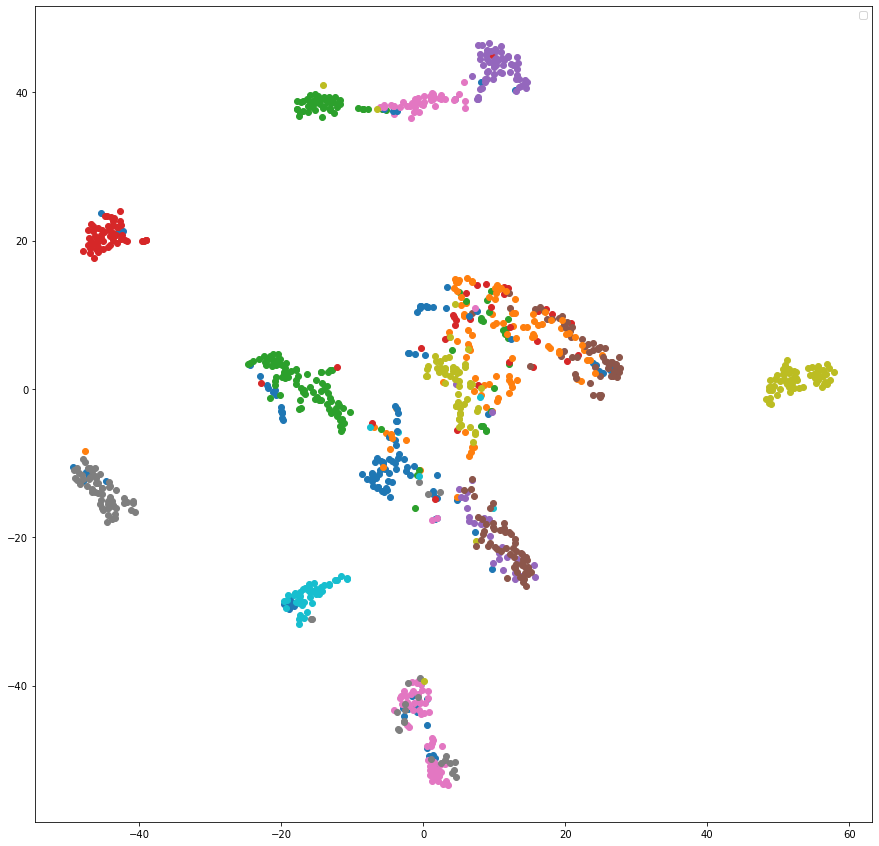

In [17]:
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(test_embeddings)
positive_list = []
for i in range(len(test_target)) :
    positive_list.append(test_target == i)

fig, ax = plt.subplots(figsize=(15, 15))

for positive in positive_list :
    ax.scatter(reduced[positive, 0], reduced[positive, 1])
#ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

## Iterate over models

cuda
(2068, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


cuda
(2068, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


cuda
(2068, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


cuda
(2068, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


cuda
(2068, 64)
(1034, 64)


/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


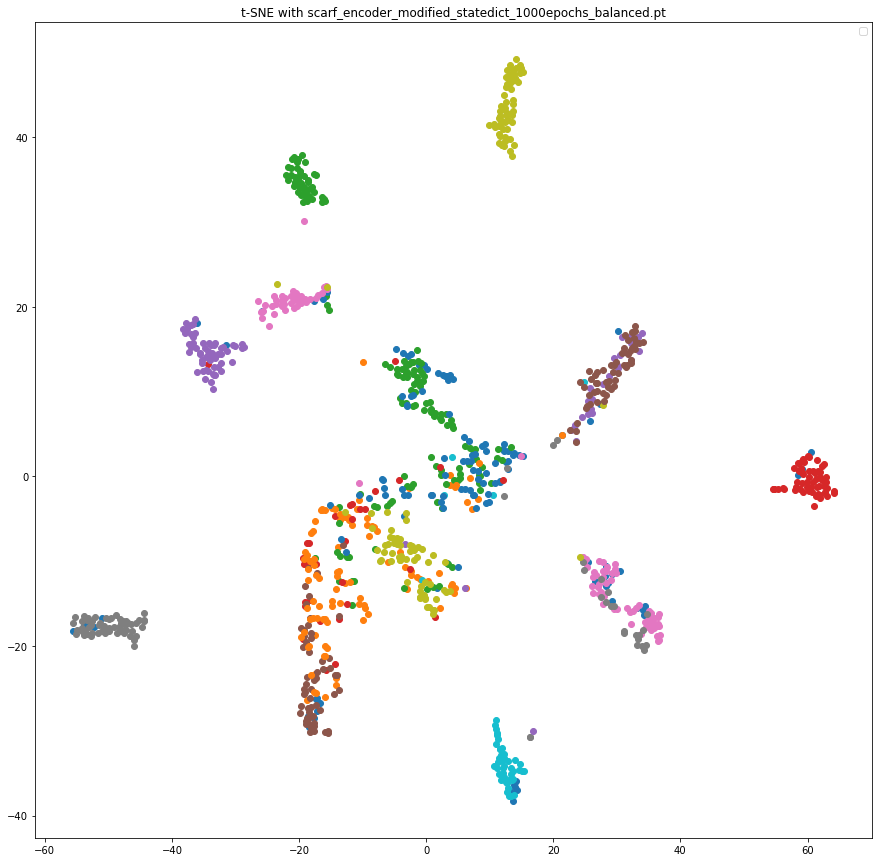

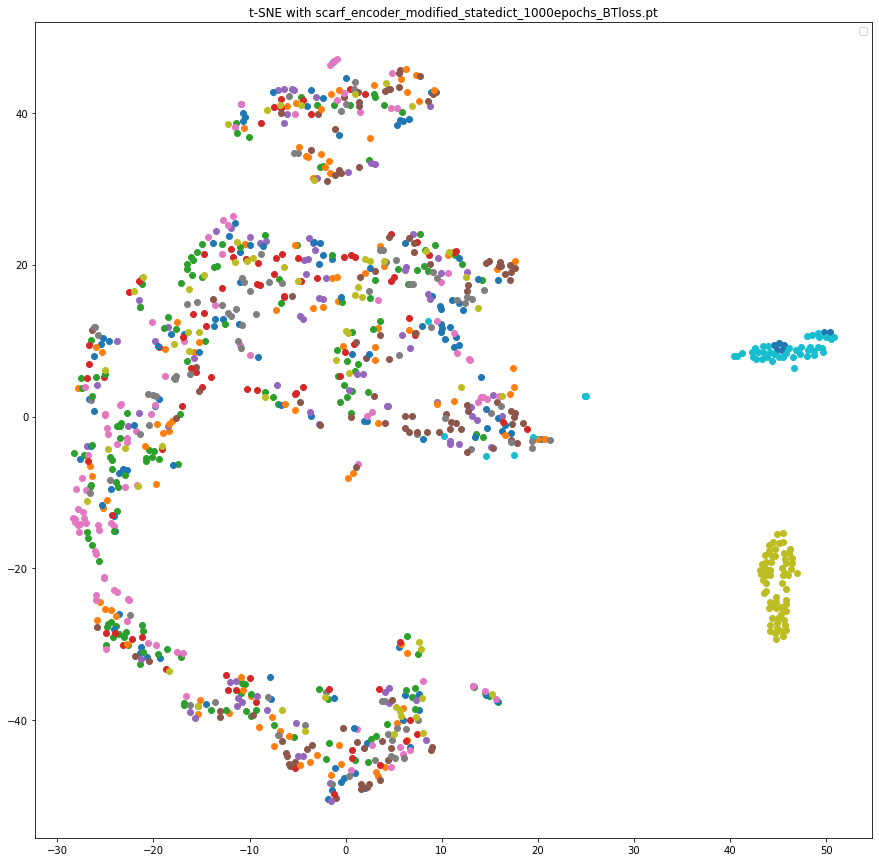

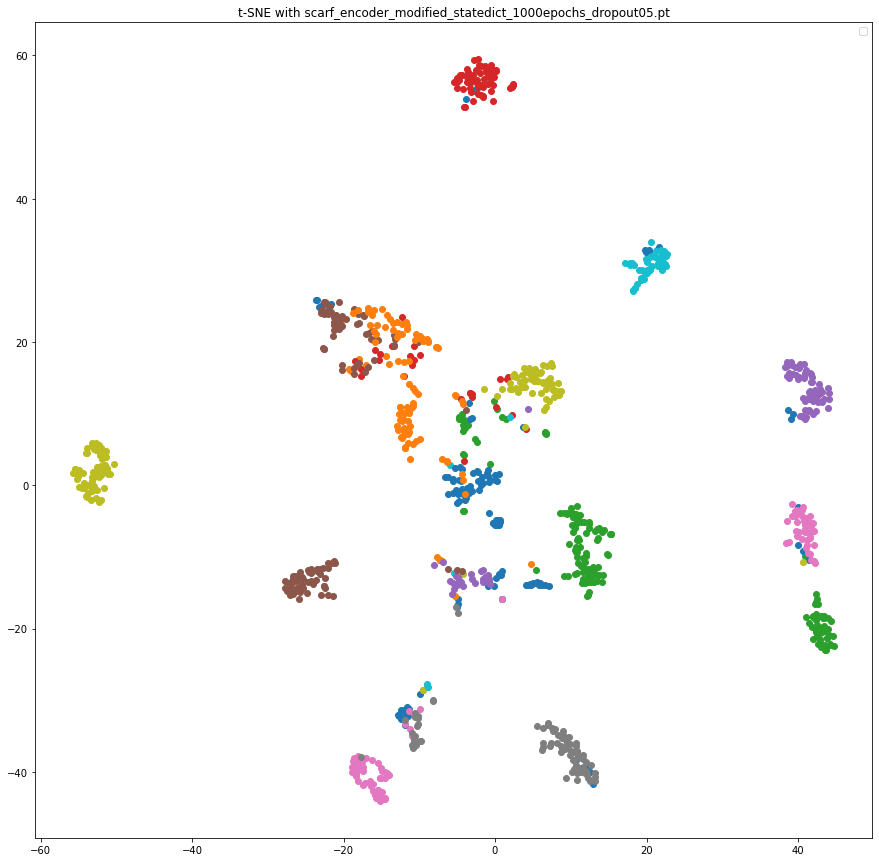

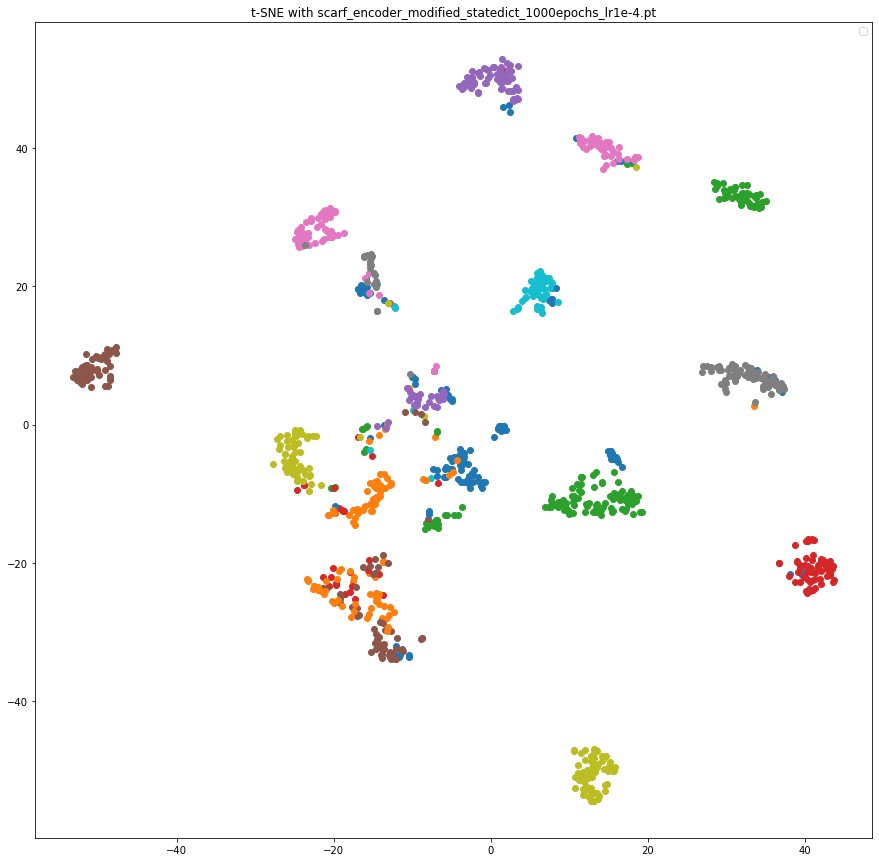

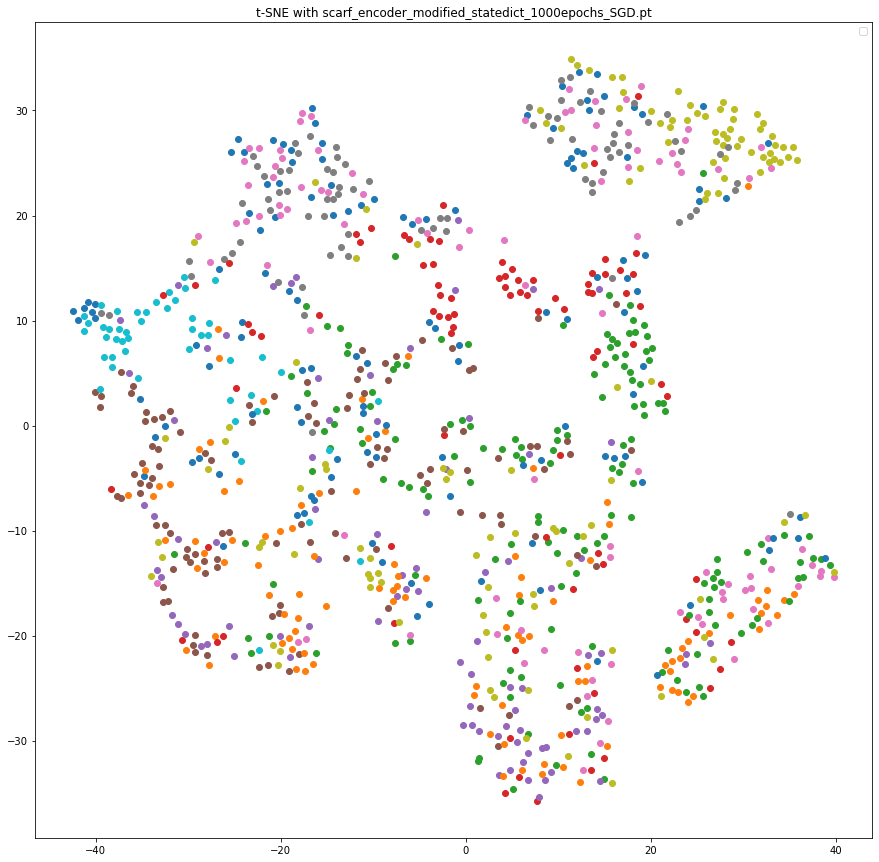

In [20]:
list_model = ["scarf_encoder_modified_statedict_1000epochs_balanced.pt", "scarf_encoder_modified_statedict_1000epochs_BTloss.pt", "scarf_encoder_modified_statedict_1000epochs_dropout05.pt", "scarf_encoder_modified_statedict_1000epochs_lr1e-4.pt", "scarf_encoder_modified_statedict_1000epochs_SGD.pt"]

for name in list_model :
    
    ########################## LOAD MODEL ######################################
    corruption_rate = 0.5
    dropout = 0.1
    batch_size = 256
    nb_classes = len(np.unique(pretrain_target))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)


    # build model
    encoder = SCARF_modified(
        input_dim=pretrain_ds.shape[1],
        emb_dim=64, # 16 by default, augment in the future
        features_low=pretrain_ds.features_low,
        features_high=pretrain_ds.features_high,
        nb_classes=nb_classes,
        corruption_rate=corruption_rate,
        dropout=dropout
    ).to(device)

    #encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs_balanced.pt"), strict=False)
    encoder.load_state_dict(torch.load(f"../saved_models/{name}"), strict=False)
    
    
    ############################ GET EMBEDDINGS #################################
    train_loader = DataLoader(finetuning_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # get embeddings for training and test set
    train_embeddings = dataset_embeddings(encoder, train_loader, device)
    test_embeddings = dataset_embeddings(encoder, test_loader, device)

    print(train_embeddings.shape)
    print(test_embeddings.shape)
    
    
    ############################## VISUALIZE AND SAVE TSNE ######################################
    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform(test_embeddings)
    positive_list = []
    for i in range(len(test_target)) :
        positive_list.append(test_target == i)

    fig, ax = plt.subplots(figsize=(15, 15))

    for positive in positive_list :
        ax.scatter(reduced[positive, 0], reduced[positive, 1])
    #ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
    plt.legend()
    plt.title(f't-SNE with {name}')
    plt.savefig(f'tsne_figures/{name}.png')

# Feature Selection

## Load data

In [2]:
from sklearn import preprocessing
import numpy as np
label_path = '../../data/TCGA/label.parquet'
data_path = '../../data/TCGA/pretrain_data.parquet'

class_df = pd.read_parquet(label_path)
data_df = pd.read_parquet(data_path)

# merging the dataframes based on "caseID"
class_df["caseID"] = class_df.apply(lambda row: row.cases.split("|")[1], axis=1)
df = class_df.merge(data_df, on="caseID", how="inner")
#df = class_df.iloc[:100].merge(data_df.iloc[:100], on="caseID", how="inner")
  
df = df.drop(columns=list(df.columns[:7]) + [df.columns[8]] + [df.columns[9]])  # columns management
    
# encoding cancer names to integers
le = preprocessing.LabelEncoder()
df["cancer_type"] = le.fit_transform(df["cancer_type"])
print(df.columns)
np_dataset = df.to_numpy(dtype=np.float32)

# normal standardardization
scaler = preprocessing.StandardScaler()
np_dataset[:, 1:] = scaler.fit_transform(np_dataset[:, 1:])
df_pretraining = pd.DataFrame(np_dataset, columns=df.columns)

##########################
pretrain_data, pretrain_target = df_pretraining.iloc[:,1:], df_pretraining.iloc[:,0]

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)


In [3]:
label_path = '../../data/TCGA/label.parquet'
data_path = '../../data/TCGA/nopretrain_data.parquet'

class_df = pd.read_parquet(label_path)
data_df = pd.read_parquet(data_path)

# merging the dataframes based on "caseID"
class_df["caseID"] = class_df.apply(lambda row: row.cases.split("|")[1], axis=1)
df = class_df.merge(data_df, on="caseID", how="inner")
#df = class_df.iloc[:100].merge(data_df.iloc[:100], on="caseID", how="inner")
  
df = df.drop(columns=list(df.columns[:7]) + [df.columns[8]] + [df.columns[9]])  # columns management
    
# encoding cancer names to integers
le = preprocessing.LabelEncoder()
df["cancer_type"] = le.fit_transform(df["cancer_type"])
print(df.columns)
np_dataset = df.to_numpy(dtype=np.float32)

# normal standardardization
scaler = preprocessing.StandardScaler()
np_dataset[:, 1:] = scaler.fit_transform(np_dataset[:, 1:])
df_finetuning = pd.DataFrame(np_dataset, columns=df.columns)

##########################
finetuning_data, finetuning_target = df_finetuning.iloc[:,1:], df_finetuning.iloc[:,0]

Index(['cancer_type', 'ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       ...
       'ENSG00000288658', 'ENSG00000288659', 'ENSG00000288660',
       'ENSG00000288662', 'ENSG00000288663', 'ENSG00000288667',
       'ENSG00000288669', 'ENSG00000288670', 'ENSG00000288674',
       'ENSG00000288675'],
      dtype='object', length=56903)


## Feature Selection

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=100).fit(pretrain_data, pretrain_target)
selector.get_support()

selected_genes = []
for mask, gene in zip(selector.get_support(), pretrain_data.columns) :
    if mask : selected_genes.append(gene)

In [5]:
len(selected_genes)

100

In [6]:
pretrain_data = pretrain_data[selected_genes]
finetuning_data = finetuning_data[selected_genes]
pretrain_data.shape, finetuning_data.shape

((7281, 100), (2068, 100))

In [7]:
# preprocess
#constant_cols = [c for c in pretrain_data.columns if pretrain_data[c].nunique() == 1]
#pretrain_data.drop(columns=constant_cols, inplace=True)
#pretrain_data.drop(columns=constant_cols, inplace=True)

# to torch dataset
pretrain_ds = ExampleDataset(
    pretrain_data.to_numpy(),
    pretrain_target.to_numpy(),
    columns=pretrain_data.columns
)

print(f"PreTrain set: {pretrain_ds.shape}")
pretrain_ds.to_dataframe().head()

PreTrain set: (7281, 100)


,ENSG00000018189,ENSG00000034053,ENSG00000040731,ENSG00000046653,ENSG00000054965,ENSG00000072832,ENSG00000078018,ENSG00000079215,ENSG00000081913,ENSG00000087258,...,ENSG00000205704,ENSG00000213760,ENSG00000242808,ENSG00000245526,ENSG00000250510,ENSG00000255389,ENSG00000255537,ENSG00000258441,ENSG00000279675,ENSG00000286190
0,-0.204181,-0.451066,-0.262390,-0.276047,-0.577319,-0.402016,-0.301911,0.054265,0.436419,-0.339449,...,-0.237779,-0.234456,-0.237820,-0.235409,-0.323925,-0.118464,0.052648,-0.166520,-0.244157,-0.318103
1,-0.303601,-0.245351,-0.234483,-0.283251,-0.270297,-0.375328,-0.349336,-0.203171,-0.245870,-0.334323,...,-0.235457,-0.239811,-0.241787,-0.234094,-0.343088,-0.414693,-0.158446,-0.347399,-0.300231,-0.321539
2,-0.761592,-0.442652,-0.262390,-0.290734,-0.669481,-0.427642,-0.343388,-0.271251,-0.367059,-0.334048,...,-0.223530,-0.242500,-0.242850,-0.227702,-0.293205,-0.414741,-0.283422,-0.257648,-0.300231,-0.318267
3,-0.255958,-0.459897,-0.262390,-0.275679,-0.808115,-0.378960,-0.341211,-0.191359,-0.126659,-0.333858,...,-0.235123,-0.104203,-0.190548,-0.236134,-0.337608,-0.371385,-0.230911,-0.072459,-0.300231,-0.268051
4,-0.619703,-0.465210,-0.262390,-0.282679,-0.724452,-0.475435,-0.343008,-0.253705,-0.229325,-0.338520,...,-0.231853,-0.223385,-0.240601,-0.236134,-0.359622,-0.398284,-0.332782,0.371438,-0.292357,-0.266978


In [8]:
# to torch dataset
finetuning_ds = ExampleDataset(
    finetuning_data.to_numpy(),
    finetuning_target.to_numpy(),
    columns=finetuning_data.columns
)

print(f"Finetuning set: {finetuning_ds.shape}")
finetuning_ds.to_dataframe().head()

Finetuning set: (2068, 100)


,ENSG00000018189,ENSG00000034053,ENSG00000040731,ENSG00000046653,ENSG00000054965,ENSG00000072832,ENSG00000078018,ENSG00000079215,ENSG00000081913,ENSG00000087258,...,ENSG00000205704,ENSG00000213760,ENSG00000242808,ENSG00000245526,ENSG00000250510,ENSG00000255389,ENSG00000255537,ENSG00000258441,ENSG00000279675,ENSG00000286190
0,-0.246006,-0.345100,-0.256476,-0.282103,-0.636813,-0.307212,-0.318737,-0.282975,-0.188276,-0.329332,...,-0.237677,-0.243946,-0.219762,-0.202117,-0.302697,-0.366480,-0.334305,-0.150205,-0.259148,-0.237216
1,-0.525127,-0.483909,-0.263047,-0.293292,-0.893632,-0.443137,-0.333237,-0.286191,-0.366554,-0.343702,...,-0.256444,-0.257556,-0.221768,-0.230207,-0.348512,-0.301886,-0.269858,-0.437716,-0.306164,-0.313780
2,-0.604658,-0.481796,-0.252485,-0.290290,-0.663507,-0.359339,-0.333869,-0.219011,-0.243889,-0.343305,...,-0.254288,-0.246810,-0.229317,-0.229844,-0.357891,-0.364960,-0.334305,-0.184241,-0.284480,-0.137982
3,-0.203005,-0.483374,-0.263047,-0.292669,-0.530255,-0.456305,-0.333762,-0.194652,0.934851,-0.346303,...,-0.201955,-0.218458,-0.212417,-0.230207,-0.368142,-0.318560,-0.284505,-0.557510,-0.306164,-0.326889
4,-0.504959,-0.379140,-0.263047,-0.285800,-0.719602,-0.395611,-0.333456,-0.277892,-0.240644,-0.324111,...,-0.203730,-0.246627,-0.223537,-0.229119,-0.338462,-0.356556,0.292584,-0.376113,-0.265588,-0.316181


## Pre-training

In [10]:
batch_size = 256
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(pretrain_ds, batch_size=batch_size, shuffle=True)

model = SCARF_modified(
    input_dim=pretrain_ds.shape[1],
    emb_dim=64,
    features_low=pretrain_ds.features_low,
    features_high=pretrain_ds.features_high,
    nb_classes = len(np.unique(pretrain_target)),
    corruption_rate=0.6,
    dropout=0.1
).to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
ntxent_loss = NTXent()

loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device)
    loss_history.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}")
        torch.save(model.state_dict(), '../saved_models/scarf_encoder_modified_statedict_1000epochs_FS.pt')


epoch 10/1000 - loss: 0.0241
epoch 20/1000 - loss: 0.0240
epoch 30/1000 - loss: 0.0239
epoch 40/1000 - loss: 0.0239
epoch 50/1000 - loss: 0.0238
epoch 60/1000 - loss: 0.0236
epoch 70/1000 - loss: 0.0234
epoch 80/1000 - loss: 0.0233
epoch 90/1000 - loss: 0.0232
epoch 100/1000 - loss: 0.0231
epoch 110/1000 - loss: 0.0230
epoch 120/1000 - loss: 0.0229
epoch 130/1000 - loss: 0.0229
epoch 140/1000 - loss: 0.0228
epoch 150/1000 - loss: 0.0229
epoch 160/1000 - loss: 0.0228
epoch 170/1000 - loss: 0.0228
epoch 180/1000 - loss: 0.0228
epoch 190/1000 - loss: 0.0228
epoch 200/1000 - loss: 0.0227
epoch 210/1000 - loss: 0.0227
epoch 220/1000 - loss: 0.0227
epoch 230/1000 - loss: 0.0226
epoch 240/1000 - loss: 0.0226
epoch 250/1000 - loss: 0.0227
epoch 260/1000 - loss: 0.0226
epoch 270/1000 - loss: 0.0226
epoch 280/1000 - loss: 0.0225
epoch 290/1000 - loss: 0.0226
epoch 300/1000 - loss: 0.0226
epoch 310/1000 - loss: 0.0226
epoch 320/1000 - loss: 0.0225
epoch 330/1000 - loss: 0.0225
epoch 340/1000 - lo

## Finetuning

In [13]:
corruption_rate = 0.6
dropout = 0.1
batch_size = 100
nb_classes = len(np.unique(pretrain_target))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# build model
encoder = SCARF_modified(
    input_dim=pretrain_ds.shape[1],
    emb_dim=64, # 16 by default, augment in the future
    features_low=pretrain_ds.features_low,
    features_high=pretrain_ds.features_high,
    nb_classes=nb_classes,
    corruption_rate=corruption_rate,
    dropout=dropout
).to(device)

encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs_FS.pt"), strict=False)

cuda


<All keys matched successfully>

In [14]:
train_loader = DataLoader(pretrain_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(finetuning_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(encoder, train_loader, device)
test_embeddings = dataset_embeddings(encoder, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

(7281, 64)
(2068, 64)


              precision    recall  f1-score   support

         0.0       0.22      0.54      0.31       145
         1.0       0.00      0.00      0.00        95
         2.0       0.14      0.89      0.24       244
         3.0       0.16      0.05      0.07        65
         4.0       0.00      0.00      0.00       102
         5.0       0.00      0.00      0.00       115
         6.0       0.00      0.00      0.00       115
         7.0       0.00      0.00      0.00        61
         8.0       0.00      0.00      0.00       123
         9.0       0.23      0.03      0.06        89
        10.0       0.00      0.00      0.00       106
        11.0       0.19      0.03      0.05       103
        12.0       0.00      0.00      0.00        90
        13.0       0.14      0.02      0.03       118
        14.0       0.00      0.00      0.00        52
        15.0       0.05      0.01      0.01       117
        16.0       0.00      0.00      0.00        96
        17.0       0.00    

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/py

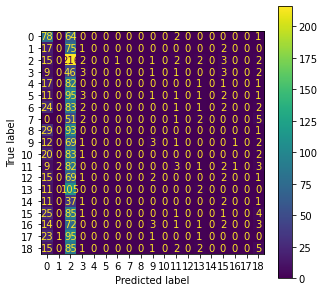

In [16]:
clf = LogisticRegression()

# embeddings dataset: train the classifier on the embeddings
clf.fit(train_embeddings, pretrain_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(finetuning_target, vanilla_predictions))
cm = confusion_matrix(finetuning_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

In [17]:
pretrain_ds.shape

(7281, 100)

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predi

              precision    recall  f1-score   support

         0.0       0.19      0.49      0.28       524
         1.0       0.15      0.01      0.02       311
         2.0       0.13      0.84      0.22       857
         3.0       0.03      0.00      0.01       241
         4.0       0.00      0.00      0.00       358
         5.0       0.00      0.00      0.00       407
         6.0       0.00      0.00      0.00       419
         7.0       0.00      0.00      0.00       230
         8.0       0.00      0.00      0.00       411
         9.0       0.10      0.01      0.02       285
        10.0       0.00      0.00      0.00       412
        11.0       0.15      0.02      0.03       398
        12.0       0.00      0.00      0.00       339
        13.0       0.06      0.01      0.01       380
        14.0       0.00      0.00      0.00       211
        15.0       0.06      0.01      0.02       355
        16.0       0.00      0.00      0.00       316
        17.0       0.00    

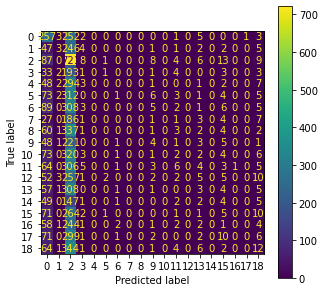

In [19]:
train_predictions = clf.predict(train_embeddings)

print(classification_report(pretrain_target, train_predictions))
cm = confusion_matrix(pretrain_target, train_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

## tSNE

/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared/software/miniconda/envs/python-pytorch-tensorflow-3.7-1.11.0-2.6.0/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


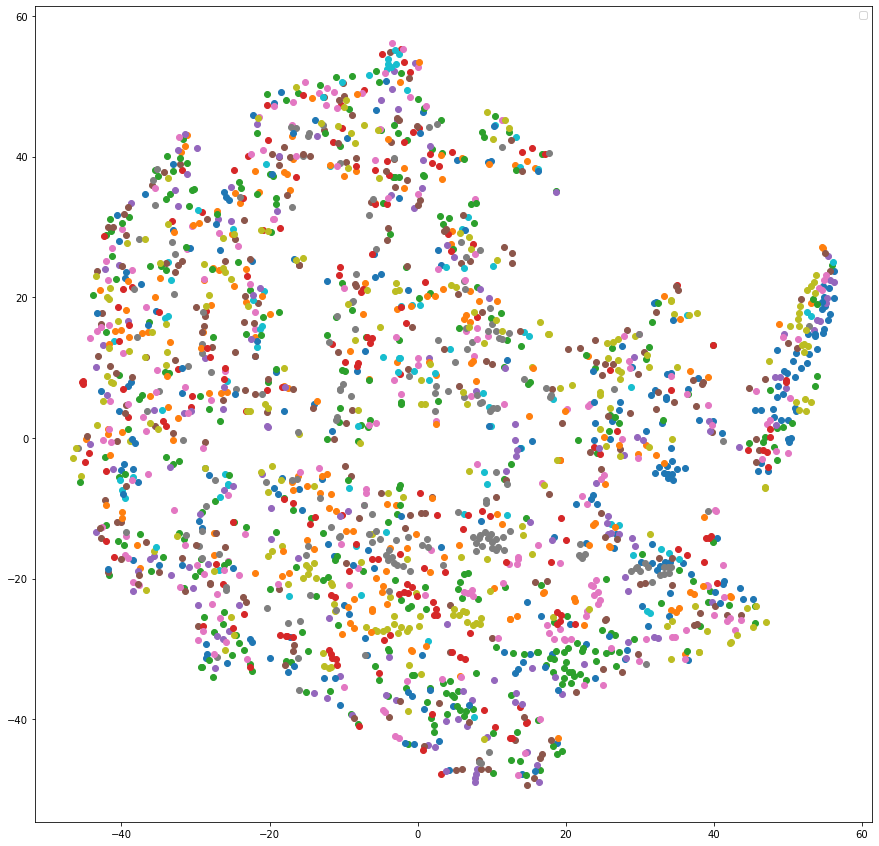

In [21]:
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(test_embeddings)
positive_list = []
for i in range(len(finetuning_target)) :
    positive_list.append(finetuning_target == i)

fig, ax = plt.subplots(figsize=(15, 15))

for positive in positive_list :
    ax.scatter(reduced[positive, 0], reduced[positive, 1])
#ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

# Microarray

## Load data

In [3]:
sys.path.append('../')
from cancerclassification.data import read_process_data_MA

In [6]:
print('Loading Data...')
dataset = read_process_data_MA(data='../../data/microarray/E-MTAB-3732.data2.parquet', label='../../data/microarray/classes.parquet', selected_type='patient')
idx = generate_indices(dataset, prop=1, val_prop=0.05, test_prop=0.05, rs=42)
len(idx[0]), len(idx[1]), len(idx[2]), len(idx[0])+len(idx[1])+len(idx[2]), len(idx[1]+idx[2])
pretrain = dataset[idx[0]]
nopretrain = dataset[idx[1]+idx[2]]

pretrain_data, pretrain_target = pretrain[:,1:], pretrain[:,0]

Loading Data...


In [8]:
pretrain_ds = ExampleDataset(
    pretrain_data,
    pretrain_target
)

In [11]:
import numpy as np
###################### LOAD MODEL ################################
corruption_rate = 0.5
dropout = 0.1
batch_size = 256
nb_classes = len(np.unique(pretrain_target))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# build model
encoder = SCARF_modified(
    input_dim=pretrain_ds.shape[1],
    emb_dim=64, # 16 by default, augment in the future
    features_low=pretrain_ds.features_low,
    features_high=pretrain_ds.features_high,
    nb_classes=nb_classes,
    corruption_rate=corruption_rate,
    dropout=dropout
).to(device)

#encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs_balanced.pt"), strict=False)
encoder.load_state_dict(torch.load("../saved_models/scarf_encoder_modified_statedict_1000epochs_MA.pt"), strict=False)

cuda


<All keys matched successfully>

In [12]:
name = "scarf_encoder_modified_statedict_1000epochs_MA.pt.csv"
prop_list = np.arange(0.02, 1.01, 0.01)
csv_history = pd.DataFrame(columns=['test_acc', 'prop'])

results = []

for prop in prop_list :
    for i in range(1) :
        print(prop)
        ################# SPLIT DATA #####################
        idx = generate_indices(nopretrain, prop=prop, val_prop=0.1, test_prop=0.5, rs=42)
        finetuning_data = nopretrain[idx[0]]
        test_data = nopretrain[idx[2]]

        finetuning_data, finetuning_target = finetuning_data[:,1:], finetuning_data[:,0]
        test_data, test_target = test_data[:,1:], test_data[:,0]

        # preprocess
        #constant_cols = [c for c in finetuning_data.columns if finetuning_data[c].nunique() == 1]
        #finetuning_data.drop(columns=constant_cols, inplace=True)

        # to torch dataset
        finetuning_ds = ExampleDataset(
            finetuning_data,
            finetuning_target
        )

        test_ds = ExampleDataset(
            test_data,
            test_target
        )

        print(f"Finetuning set: {finetuning_ds.shape}")
        print(f"Test set: {test_ds.shape}")
        
        
        ################## GET EMBEDDINGS ##########################
        train_loader = DataLoader(finetuning_ds, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

        # get embeddings for training and test set
        train_embeddings = dataset_embeddings(encoder, train_loader, device)
        test_embeddings = dataset_embeddings(encoder, test_loader, device)

        print(train_embeddings.shape)
        print(test_embeddings.shape)
        
        
        ######################### TRAIN LOGREG ####################################
        # embeddings dataset: train the classifier on the embeddings
        clf = LogisticRegression()

        clf.fit(train_embeddings, finetuning_target)
        vanilla_predictions = clf.predict(test_embeddings)

        print(classification_report(test_target, vanilla_predictions))
        
        results.append(clf.score(test_embeddings, test_target))
        
        ################ SAVE CSV ######################
        csv_history.loc[len(csv_history)] = [results[-1], prop]
    csv_history.to_csv(name)

0.02
17
Finetuning set: (17, 54675)
Test set: (1063, 54675)
(17, 64)
(1063, 64)
              precision    recall  f1-score   support

         0.0       0.56      0.38      0.45       379
         1.0       0.71      0.84      0.77       684

    accuracy                           0.67      1063
   macro avg       0.63      0.61      0.61      1063
weighted avg       0.66      0.67      0.65      1063

0.03
25
Finetuning set: (25, 54675)
Test set: (1063, 54675)
(25, 64)
(1063, 64)
              precision    recall  f1-score   support

         0.0       0.73      0.45      0.56       379
         1.0       0.75      0.91      0.82       684

    accuracy                           0.74      1063
   macro avg       0.74      0.68      0.69      1063
weighted avg       0.74      0.74      0.73      1063

0.039999999999999994
34
Finetuning set: (34, 54675)
Test set: (1063, 54675)
(34, 64)
(1063, 64)
              precision    recall  f1-score   support

         0.0       0.72      0.48  